Importing all the libraries for the project

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from numpy import loadtxt
from keras.callbacks import EarlyStopping
from matplotlib import pyplot

2022-11-07 17:35:30.482675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 17:35:30.615903: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-07 17:35:30.615921: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-07 17:35:30.641944: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 17:35:31.197869: W tensorflow/stream_executor/platform/de

In [2]:
# Fix a random seed for both TensorFlow and Numpy
seed = 2
tf.random.set_seed(seed)
np.random.seed(seed)

Loading the training set to train the first neural network

In [3]:
tr = loadtxt("dataset/monk1/monks-1.train", dtype='str', delimiter=' ')
# The first column and the last of this matrix don't contain any useful information for our project,
# so we can delete them
tr = np.delete(tr, [0, 8], 1) 
# Now the first column of the matrix contains the target, while the other six the input for the NN. Let us now 
# convert to integers all the values of the matrix
tr = tr.astype(int)
tr[:20]

array([[1, 1, 1, 1, 1, 3, 1],
       [1, 1, 1, 1, 1, 3, 2],
       [1, 1, 1, 1, 3, 2, 1],
       [1, 1, 1, 1, 3, 3, 2],
       [1, 1, 1, 2, 1, 2, 1],
       [1, 1, 1, 2, 1, 2, 2],
       [1, 1, 1, 2, 2, 3, 1],
       [1, 1, 1, 2, 2, 4, 1],
       [1, 1, 1, 2, 3, 1, 2],
       [1, 1, 2, 1, 1, 1, 2],
       [0, 1, 2, 1, 1, 2, 1],
       [0, 1, 2, 1, 1, 3, 1],
       [0, 1, 2, 1, 1, 4, 2],
       [1, 1, 2, 1, 2, 1, 1],
       [0, 1, 2, 1, 2, 3, 1],
       [0, 1, 2, 1, 2, 3, 2],
       [0, 1, 2, 1, 2, 4, 2],
       [0, 1, 2, 1, 3, 2, 1],
       [0, 1, 2, 1, 3, 4, 2],
       [0, 1, 2, 2, 1, 2, 2]])

At this point we are ready to divide the column of the matrix into target and input. In this case the target is the first column of the matrix, while the input are the other 6 columns

In [4]:
# target
y = tr[:, 0]
# input
x = tr[:, 1:7]

Now we need to implement early stopping to understand where we have to stop the training of our neural network, for this reason we need to split our dataset to distinguish between the training set and the validation set

In [5]:
print("size of the design set", len(x))

# we are going to use 30% of our training set as the validation set
subset_size = int(0.3 * len(x))

# find randomly the indexes of the rows for the validation set
index = np.random.choice(len(x), subset_size, replace=False)
index = np.sort(index)

# create the validation set
vl_x = x[index]
vl_y = y[index]

# create the training set
tr_x = np.delete(x, index, 0)
tr_y = np.delete(y, index, 0)

print("size of the training set", len(tr_x))
print("size of the validation set", len(vl_y))

size of the design set 124
size of the training set 87
size of the validation set 37


So we are now ready to build the neural network

In [59]:
# Function to create a model, it is required to perform a grid search over the hyper-parameters
def create_model():
    # (From Keras documentation) A Sequential model is appropriate for a plain stack of layers where each layer 
    # has exactly one input tensor and one output tensor. 
    # In other words, in a sequential model, the input flows sequentially from the first layers to the last one,
    # without self-loops or backward edges
    model = Sequential();
    # The dense class is used to implement a densely connected neural network, which is a neural network where each 
    # input is connected to every output by a weight.
    # The parameter "input_space" specify the size of the input space (in this case 6, since there are exactly
    # 6 columns in tr_x). This parameter must be added to the first hidden layer of the NN.
    model.add(Dense(3, input_dim=6, activation="relu"))
    # We have added a hidden layer to our neural network (which also works as an input layer, since it fetches the
    # input), now let's add similarly an output layer.
    model.add(Dense(1, activation="sigmoid"))
    # Now we can compile the neural network. To compile it we need to specify: the loss function (which is
    # binary_crossentropy for binary classificatio), the optimizer (in this case we'll use adam, which is an 
    # efficient stochastic gradient descent algorithm), the metrics to collect and report the performance of the
    # neural network (in this case we will use the accuracy, since it is a classification problem).
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Keras models can be used in scikit-learn by wrapping them with the KerasClassifier or KerasRegressor class from the module SciKeras. We will use the KerasClassifier since we have to solve a classification problem.

In [60]:
# The parameter verbose = 0 is used to silence the output.
model = KerasClassifier(model=create_model, verbose=0)

Now we need to define the values and the hyperparameters for the grid search. Below there is a list of hyperparameters that we'll consider for the grid search.

1. The learning rate for the gradient descent algorithm
2. the value of alpha for momentum

In [65]:
learn_rate = [0.01, 0.1, 0.2, 0.4]
momentum = [0.1, 0.2, 0.3, 0.6, 0.9]

# In the SciKeras wrapper, to route the parameters to the optimizer we need the prefix optimizer__.
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)

In [66]:
# GridSearchCV is used to perform an exhaustive search over specified parameter values for an estimator. We will use
# it to find the best set of hyper-parameters for the model selection of our neural network.
# param_grid = Dictionary with parameters names (str) as keys and lists of parameter settings to try as values.
# n_jobs = Number of jobs to run in parallel, the value -1 will use all the available processors.
# cv = number of folds of the cross validation.
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, error_score="raise")

# a simple condition for early stopping. Patience stops the training only if the loss on the validation set rose
# for a number of consecutive epochs 
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

'''
grid_result = grid.fit(
    tr_x, tr_y, # training set
    validation_data=(vl_x, vl_y), # validation set
    verbose=1, # to print the results
    shuffle=True, # shuffle before each epoch
    callbacks=[es], # callbacks to be executed at the end of each epoch
    epochs = 500 # ELIMINA POI
)'''

grid_result = grid.fit(
    x, y, # training set
    validation_split=0.3, # validation set's dimension
    verbose=1, # to print the results
    shuffle=True, # shuffle before each epoch
    callbacks=[es], # callbacks to be executed at the end of each epoch
    epochs = 100 # ELIMINA POI
)

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
2/2 [==============================] - 1s 224ms/step - loss: 0.7925 - accuracy: 0.6744 - val_loss: 1.8775 - val_accuracy: 0.1053
Epoch 2/100
Epoch 2/100
2/2 [==============================] - 1s 225ms/step - loss: 0.8046 - accuracy: 0.4419 - val_loss: 0.6560 - val_accuracy: 0.2632
Epoch 2/100
2/2 [==============================] - 1s 237ms/step - loss: 0.9080 - accuracy: 0.2791 - val_loss: 0.5364 - val_accuracy: 0.8947
Epoch 2/100
Epoch 2/100
2/2 [==============================] - 1s 225ms/step - loss: 3.7536 - accuracy: 0.3256 - val_loss: 0.6883 - val_accuracy: 0.8947
Epoch 3/100
Epoch 2/100
2/2 [==============================] - 1s 223ms/step - loss: 0.7435 - accuracy: 0.6744 - val_loss: 1.8903 - val_accuracy: 0.1053
Epoch 2/100
2/2 [==============================] - 0s 51ms/step - loss: 0.5815 - accuracy: 0.6744 - val_loss: 1.2437 - val_accuracy: 0.1053
Epoch 3/100
Epoch 3/100
2/2 [======

2/2 [==============================] - 0s 43ms/step - loss: 0.5778 - accuracy: 0.6744 - val_loss: 1.2676 - val_accuracy: 0.1053
Epoch 10/100
Epoch 10/100
Epoch 11/100
2/2 [==============================] - 0s 59ms/step - loss: 0.7173 - accuracy: 0.6744 - val_loss: 1.7368 - val_accuracy: 0.1053
Epoch 10/100
2/2 [==============================] - 0s 31ms/step - loss: 3.3200 - accuracy: 0.3256 - val_loss: 0.6192 - val_accuracy: 0.8947
Epoch 11/100
2/2 [==============================] - 0s 35ms/step - loss: 0.8516 - accuracy: 0.2791 - val_loss: 0.5785 - val_accuracy: 0.7895
Epoch 11/100
2/2 [==============================] - 0s 38ms/step - loss: 0.5773 - accuracy: 0.6744 - val_loss: 1.2690 - val_accuracy: 0.1053
Epoch 12/100
2/2 [==============================] - 0s 34ms/step - loss: 0.7151 - accuracy: 0.6744 - val_loss: 1.7183 - val_accuracy: 0.1053
Epoch 12/100
Epoch 11/100
2/2 [==============================] - 0s 56ms/step - loss: 0.9738 - accuracy: 0.6744 - val_loss: 2.4703 - val_accu

Epoch 15/100
Epoch 15/100
2/2 [==============================] - 0s 43ms/step - loss: 0.7056 - accuracy: 0.6744 - val_loss: 1.6582 - val_accuracy: 0.1053
Epoch 15/100
2/2 [==============================] - 0s 38ms/step - loss: 0.7483 - accuracy: 0.4884 - val_loss: 0.6682 - val_accuracy: 0.1579
Epoch 15/100
Epoch 14/100
2/2 [==============================] - 0s 37ms/step - loss: 3.0913 - accuracy: 0.3256 - val_loss: 0.5862 - val_accuracy: 0.8947
Epoch 16/100
Epoch 16/100
2/2 [==============================] - 0s 58ms/step - loss: 0.7282 - accuracy: 0.6744 - val_loss: 1.5761 - val_accuracy: 0.1053
Epoch 16/100
2/2 [==============================] - 0s 38ms/step - loss: 0.8225 - accuracy: 0.2558 - val_loss: 0.6030 - val_accuracy: 0.7895
Epoch 16/100
2/2 [==============================] - 0s 37ms/step - loss: 0.7441 - accuracy: 0.4884 - val_loss: 0.6688 - val_accuracy: 0.1579
Epoch 15/100
2/2 [==============================] - 0s 43ms/step - loss: 0.5896 - accuracy: 0.6744 - val_loss: 1.14

2/2 [==============================] - 0s 39ms/step - loss: 0.7157 - accuracy: 0.6744 - val_loss: 1.5090 - val_accuracy: 0.1053
Epoch 20/100
2/2 [==============================] - 0s 42ms/step - loss: 0.6987 - accuracy: 0.6744 - val_loss: 1.6001 - val_accuracy: 0.1053
Epoch 19/100
2/2 [==============================] - 0s 37ms/step - loss: 0.8023 - accuracy: 0.2791 - val_loss: 0.6258 - val_accuracy: 0.7895
Epoch 20/100
2/2 [==============================] - 0s 35ms/step - loss: 0.7318 - accuracy: 0.4884 - val_loss: 0.6708 - val_accuracy: 0.2105
Epoch 20/100
Epoch 18/100
2/2 [==============================] - 0s 52ms/step - loss: 2.9141 - accuracy: 0.3256 - val_loss: 0.5602 - val_accuracy: 0.8947
Epoch 20/100
2/2 [==============================] - 0s 47ms/step - loss: 0.5730 - accuracy: 0.6744 - val_loss: 1.2957 - val_accuracy: 0.1053
Epoch 22/100
2/2 [==============================] - 0s 34ms/step - loss: 0.6969 - accuracy: 0.6744 - val_loss: 1.5888 - val_accuracy: 0.1053
Epoch 20/100


2/2 [==============================] - 0s 44ms/step - loss: 0.7011 - accuracy: 0.6744 - val_loss: 1.4385 - val_accuracy: 0.1053
Epoch 25/100
2/2 [==============================] - 0s 35ms/step - loss: 0.6906 - accuracy: 0.6744 - val_loss: 1.5453 - val_accuracy: 0.1053
Epoch 24/100
2/2 [==============================] - 0s 40ms/step - loss: 0.8919 - accuracy: 0.6744 - val_loss: 2.2814 - val_accuracy: 0.1053
Epoch 24/100
2/2 [==============================] - 0s 35ms/step - loss: 0.5845 - accuracy: 0.6744 - val_loss: 1.1472 - val_accuracy: 0.1579
Epoch 27/100
Epoch 25/100
2/2 [==============================] - 0s 33ms/step - loss: 0.7138 - accuracy: 0.5349 - val_loss: 0.6777 - val_accuracy: 0.2632
Epoch 23/100
2/2 [==============================] - 0s 33ms/step - loss: 0.6898 - accuracy: 0.6744 - val_loss: 1.5343 - val_accuracy: 0.1053
Epoch 25/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6953 - accuracy: 0.6562Epoch 25/100
Epoch 26/100
2/2 [==============================

2/2 [==============================] - 0s 49ms/step - loss: 0.6921 - accuracy: 0.6744 - val_loss: 1.3858 - val_accuracy: 0.1053
Epoch 29/100
2/2 [==============================] - 0s 70ms/step - loss: 0.5695 - accuracy: 0.6744 - val_loss: 1.3155 - val_accuracy: 0.1053
Epoch 30/100
2/2 [==============================] - 0s 37ms/step - loss: 0.8648 - accuracy: 0.6744 - val_loss: 2.2255 - val_accuracy: 0.1053
Epoch 30/100
2/2 [==============================] - 0s 45ms/step - loss: 0.5820 - accuracy: 0.6744 - val_loss: 1.1432 - val_accuracy: 0.1579
Epoch 29/100
2/2 [==============================] - 0s 40ms/step - loss: 0.7573 - accuracy: 0.4186 - val_loss: 0.7088 - val_accuracy: 0.5789
Epoch 29/100
2/2 [==============================] - 0s 35ms/step - loss: 0.6895 - accuracy: 0.6744 - val_loss: 1.3751 - val_accuracy: 0.1053
Epoch 30/100
2/2 [==============================] - 0s 54ms/step - loss: 2.5269 - accuracy: 0.3256 - val_loss: 0.5037 - val_accuracy: 0.8947
Epoch 29/100
2/2 [========

2/2 [==============================] - 0s 68ms/step - loss: 0.6835 - accuracy: 0.6744 - val_loss: 1.3429 - val_accuracy: 0.1053
Epoch 33/100
2/2 [==============================] - 0s 63ms/step - loss: 0.6972 - accuracy: 0.6279 - val_loss: 0.6900 - val_accuracy: 0.2632
Epoch 34/100
Epoch 30/100
2/2 [==============================] - 0s 51ms/step - loss: 2.4064 - accuracy: 0.3256 - val_loss: 0.4859 - val_accuracy: 0.8947
Epoch 32/100
2/2 [==============================] - 0s 48ms/step - loss: 0.5798 - accuracy: 0.6744 - val_loss: 1.1312 - val_accuracy: 0.1579
Epoch 32/100
Epoch 33/100
2/2 [==============================] - 0s 51ms/step - loss: 0.8431 - accuracy: 0.6744 - val_loss: 2.1810 - val_accuracy: 0.1053
Epoch 34/100
2/2 [==============================] - 0s 70ms/step - loss: 0.7400 - accuracy: 0.4186 - val_loss: 0.7466 - val_accuracy: 0.5263
Epoch 32/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6954 - accuracy: 0.6744 - val_loss: 0.6916 - val_accuracy: 0.2632


2/2 [==============================] - 0s 52ms/step - loss: 0.8265 - accuracy: 0.6744 - val_loss: 2.1498 - val_accuracy: 0.1053
Epoch 37/100
2/2 [==============================] - 0s 43ms/step - loss: 0.7248 - accuracy: 0.4186 - val_loss: 0.7885 - val_accuracy: 0.4737
Epoch 35/100
2/2 [==============================] - 0s 46ms/step - loss: 2.2609 - accuracy: 0.3256 - val_loss: 0.4677 - val_accuracy: 0.8947
Epoch 36/100
2/2 [==============================] - 0s 54ms/step - loss: 0.5661 - accuracy: 0.6744 - val_loss: 1.3197 - val_accuracy: 0.1053
Epoch 38/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6920 - accuracy: 0.6744 - val_loss: 0.6959 - val_accuracy: 0.2632
Epoch 37/100
Epoch 34/100
2/2 [==============================] - 0s 55ms/step - loss: 0.5776 - accuracy: 0.6744 - val_loss: 1.1238 - val_accuracy: 0.1579
Epoch 37/100
2/2 [==============================] - 0s 59ms/step - loss: 0.6784 - accuracy: 0.6744 - val_loss: 1.4525 - val_accuracy: 0.1053
Epoch 37/100


2/2 [==============================] - 0s 51ms/step - loss: 0.7051 - accuracy: 0.5349 - val_loss: 0.8402 - val_accuracy: 0.2632
Epoch 39/100
2/2 [==============================] - 0s 33ms/step - loss: 0.6760 - accuracy: 0.6744 - val_loss: 1.4337 - val_accuracy: 0.1053
Epoch 41/100
Epoch 42/100
Epoch 41/100
Epoch 39/100
2/2 [==============================] - 0s 45ms/step - loss: 0.5639 - accuracy: 0.6744 - val_loss: 1.3258 - val_accuracy: 0.1053
Epoch 43/100
2/2 [==============================] - 0s 55ms/step - loss: 0.6889 - accuracy: 0.6279 - val_loss: 0.7012 - val_accuracy: 0.2105
Epoch 38/100
2/2 [==============================] - 0s 40ms/step - loss: 0.7015 - accuracy: 0.5581 - val_loss: 0.8539 - val_accuracy: 0.2105
Epoch 40/100
Epoch 40/100
2/2 [==============================] - 0s 40ms/step - loss: 0.7936 - accuracy: 0.6744 - val_loss: 2.0814 - val_accuracy: 0.1053
Epoch 43/100
2/2 [==============================] - 0s 55ms/step - loss: 2.0432 - accuracy: 0.3256 - val_loss: 0.44

2/2 [==============================] - 0s 33ms/step - loss: 1.9099 - accuracy: 0.3256 - val_loss: 0.4311 - val_accuracy: 0.8947
Epoch 45/100
Epoch 46/100
Epoch 46/100
2/2 [==============================] - 0s 55ms/step - loss: 0.6866 - accuracy: 0.6512 - val_loss: 0.7055 - val_accuracy: 0.1579
Epoch 42/100
2/2 [==============================] - 0s 37ms/step - loss: 0.5616 - accuracy: 0.6744 - val_loss: 1.3395 - val_accuracy: 0.1053
Epoch 48/100
2/2 [==============================] - 0s 49ms/step - loss: 0.6888 - accuracy: 0.5581 - val_loss: 0.9008 - val_accuracy: 0.2105
Epoch 44/100
2/2 [==============================] - 0s 36ms/step - loss: 0.6721 - accuracy: 0.6744 - val_loss: 1.4133 - val_accuracy: 0.1053
Epoch 45/100
2/2 [==============================] - 0s 36ms/step - loss: 0.5720 - accuracy: 0.6744 - val_loss: 1.1306 - val_accuracy: 0.1579
Epoch 46/100
2/2 [==============================] - 0s 43ms/step - loss: 1.8788 - accuracy: 0.3256 - val_loss: 0.4279 - val_accuracy: 0.8947


2/2 [==============================] - 0s 47ms/step - loss: 0.5695 - accuracy: 0.6744 - val_loss: 1.1277 - val_accuracy: 0.1579
Epoch 50/100
2/2 [==============================] - 0s 39ms/step - loss: 0.6845 - accuracy: 0.6744 - val_loss: 0.7102 - val_accuracy: 0.1579
Epoch 46/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6698 - accuracy: 0.6744 - val_loss: 1.4021 - val_accuracy: 0.1053
Epoch 48/100
Epoch 49/100
2/2 [==============================] - 0s 36ms/step - loss: 0.7495 - accuracy: 0.6744 - val_loss: 1.9883 - val_accuracy: 0.1053
Epoch 51/100
2/2 [==============================] - 0s 41ms/step - loss: 0.5593 - accuracy: 0.6744 - val_loss: 1.3462 - val_accuracy: 0.1053
Epoch 53/100
2/2 [==============================] - 0s 34ms/step - loss: 0.5689 - accuracy: 0.6744 - val_loss: 1.1276 - val_accuracy: 0.1579
Epoch 51/100
2/2 [==============================] - 0s 35ms/step - loss: 0.6749 - accuracy: 0.5814 - val_loss: 0.9430 - val_accuracy: 0.2105
Epoch 47/100


2/2 [==============================] - 0s 46ms/step - loss: 0.6564 - accuracy: 0.6744 - val_loss: 1.1697 - val_accuracy: 0.1053
Epoch 54/100
2/2 [==============================] - 0s 32ms/step - loss: 0.7233 - accuracy: 0.6744 - val_loss: 1.9036 - val_accuracy: 0.1053
Epoch 56/100
2/2 [==============================] - 0s 43ms/step - loss: 1.6063 - accuracy: 0.3256 - val_loss: 0.4049 - val_accuracy: 0.8947
Epoch 56/100
2/2 [==============================] - 0s 36ms/step - loss: 0.6635 - accuracy: 0.5814 - val_loss: 0.9827 - val_accuracy: 0.1053
Epoch 58/100
Epoch 53/100
2/2 [==============================] - 0s 61ms/step - loss: 0.6811 - accuracy: 0.6744 - val_loss: 0.7149 - val_accuracy: 0.1579
Epoch 51/100
2/2 [==============================] - 0s 53ms/step - loss: 0.6556 - accuracy: 0.6744 - val_loss: 1.1637 - val_accuracy: 0.1053
Epoch 57/100
Epoch 55/100
2/2 [==============================] - 0s 34ms/step - loss: 0.5564 - accuracy: 0.6744 - val_loss: 1.3551 - val_accuracy: 0.1053


2/2 [==============================] - 0s 32ms/step - loss: 0.6786 - accuracy: 0.6744 - val_loss: 0.7182 - val_accuracy: 0.1579
Epoch 59/100
Epoch 55/100
2/2 [==============================] - 0s 32ms/step - loss: 0.6525 - accuracy: 0.6744 - val_loss: 1.1436 - val_accuracy: 0.1053
Epoch 59/100
2/2 [==============================] - 0s 37ms/step - loss: 0.6980 - accuracy: 0.6744 - val_loss: 1.8514 - val_accuracy: 0.1053
Epoch 61/100
2/2 [==============================] - 0s 60ms/step - loss: 0.5550 - accuracy: 0.6744 - val_loss: 1.3616 - val_accuracy: 0.1053
Epoch 62/100
2/2 [==============================] - 0s 39ms/step - loss: 1.4943 - accuracy: 0.3256 - val_loss: 0.3980 - val_accuracy: 0.8947
Epoch 60/100
2/2 [==============================] - 0s 38ms/step - loss: 0.5634 - accuracy: 0.6744 - val_loss: 1.1398 - val_accuracy: 0.1579
Epoch 60/100
2/2 [==============================] - 0s 31ms/step - loss: 0.6639 - accuracy: 0.6744 - val_loss: 1.3755 - val_accuracy: 0.1053
Epoch 59/100


2/2 [==============================] - 0s 42ms/step - loss: 0.5610 - accuracy: 0.6744 - val_loss: 1.1394 - val_accuracy: 0.1053
Epoch 64/100
2/2 [==============================] - 0s 51ms/step - loss: 0.6761 - accuracy: 0.6744 - val_loss: 0.7221 - val_accuracy: 0.1579
Epoch 63/100
Epoch 60/100
2/2 [==============================] - 0s 52ms/step - loss: 0.6744 - accuracy: 0.6744 - val_loss: 1.7958 - val_accuracy: 0.1053
Epoch 66/100
2/2 [==============================] - 0s 34ms/step - loss: 0.5605 - accuracy: 0.6744 - val_loss: 1.1396 - val_accuracy: 0.1053
Epoch 65/100
Epoch 65/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6485 - accuracy: 0.6744 - val_loss: 1.1221 - val_accuracy: 0.1053
Epoch 64/100
Epoch 64/100
2/2 [==============================] - 0s 46ms/step - loss: 0.5521 - accuracy: 0.6744 - val_loss: 1.3756 - val_accuracy: 0.1053
Epoch 68/100
2/2 [==============================] - 0s 33ms/step - loss: 0.6698 - accuracy: 0.6744 - val_loss: 1.7838 - val_accu

2/2 [==============================] - 0s 36ms/step - loss: 1.2842 - accuracy: 0.3256 - val_loss: 0.3927 - val_accuracy: 0.8947
Epoch 68/100
2/2 [==============================] - 0s 52ms/step - loss: 0.6459 - accuracy: 0.6744 - val_loss: 1.1085 - val_accuracy: 0.1053
Epoch 68/100
2/2 [==============================] - 0s 35ms/step - loss: 0.5581 - accuracy: 0.6744 - val_loss: 1.1451 - val_accuracy: 0.1053
Epoch 71/100
2/2 [==============================] - 0s 59ms/step - loss: 0.6592 - accuracy: 0.6744 - val_loss: 1.3473 - val_accuracy: 0.1053
Epoch 69/100
2/2 [==============================] - 0s 38ms/step - loss: 0.6288 - accuracy: 0.6744 - val_loss: 1.1257 - val_accuracy: 0.0526
Epoch 64/100
Epoch 66/100
2/2 [==============================] - 0s 55ms/step - loss: 0.5502 - accuracy: 0.6744 - val_loss: 1.3816 - val_accuracy: 0.1053
Epoch 72/100
2/2 [==============================] - 0s 44ms/step - loss: 1.2605 - accuracy: 0.3023 - val_loss: 0.3929 - val_accuracy: 0.8947
Epoch 69/100


2/2 [==============================] - 0s 32ms/step - loss: 0.6205 - accuracy: 0.6977 - val_loss: 1.1709 - val_accuracy: 0.0526
Epoch 71/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6730 - accuracy: 0.6512 - val_loss: 0.7280 - val_accuracy: 0.1579
Epoch 73/100
Epoch 68/100
2/2 [==============================] - 0s 36ms/step - loss: 0.5551 - accuracy: 0.6744 - val_loss: 1.1520 - val_accuracy: 0.1053
Epoch 74/100
2/2 [==============================] - 0s 55ms/step - loss: 0.6432 - accuracy: 0.6744 - val_loss: 1.1014 - val_accuracy: 0.1053
Epoch 72/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6561 - accuracy: 0.6744 - val_loss: 1.3286 - val_accuracy: 0.1053
Epoch 72/100
2/2 [==============================] - 0s 50ms/step - loss: 0.6298 - accuracy: 0.6744 - val_loss: 1.6930 - val_accuracy: 0.1053
Epoch 76/100
2/2 [==============================] - 0s 40ms/step - loss: 0.6192 - accuracy: 0.6977 - val_loss: 1.1781 - val_accuracy: 0.1053
Epoch 72/100


2/2 [==============================] - 0s 34ms/step - loss: 0.6710 - accuracy: 0.6744 - val_loss: 0.7314 - val_accuracy: 0.1579
Epoch 77/100
Epoch 73/100
2/2 [==============================] - 0s 37ms/step - loss: 1.0783 - accuracy: 0.3256 - val_loss: 0.4041 - val_accuracy: 0.8947
Epoch 79/100
Epoch 78/100
2/2 [==============================] - 0s 37ms/step - loss: 0.6401 - accuracy: 0.6744 - val_loss: 1.0939 - val_accuracy: 0.1053
Epoch 77/100
2/2 [==============================] - 0s 53ms/step - loss: 0.6135 - accuracy: 0.6977 - val_loss: 1.1978 - val_accuracy: 0.1053
Epoch 76/100
2/2 [==============================] - 0s 50ms/step - loss: 0.6128 - accuracy: 0.6744 - val_loss: 1.6729 - val_accuracy: 0.1053
Epoch 80/100
2/2 [==============================] - 0s 33ms/step - loss: 0.6532 - accuracy: 0.6744 - val_loss: 1.3190 - val_accuracy: 0.1053
Epoch 78/100
2/2 [==============================] - 0s 52ms/step - loss: 0.5528 - accuracy: 0.6744 - val_loss: 1.1503 - val_accuracy: 0.1053


2/2 [==============================] - 0s 32ms/step - loss: 0.5506 - accuracy: 0.6977 - val_loss: 1.1409 - val_accuracy: 0.1053
Epoch 82/100
2/2 [==============================] - 0s 51ms/step - loss: 0.5439 - accuracy: 0.6744 - val_loss: 1.3714 - val_accuracy: 0.1053
Epoch 84/100
2/2 [==============================] - 0s 43ms/step - loss: 0.6368 - accuracy: 0.6744 - val_loss: 1.0804 - val_accuracy: 0.1053
Epoch 82/100
2/2 [==============================] - 0s 35ms/step - loss: 0.6073 - accuracy: 0.6977 - val_loss: 1.2161 - val_accuracy: 0.1053
Epoch 81/100
2/2 [==============================] - 0s 52ms/step - loss: 0.5935 - accuracy: 0.6744 - val_loss: 1.6605 - val_accuracy: 0.1053
Epoch 85/100
2/2 [==============================] - 0s 51ms/step - loss: 0.6508 - accuracy: 0.6744 - val_loss: 1.3028 - val_accuracy: 0.1053
Epoch 83/100
Epoch 83/100
2/2 [==============================] - 0s 50ms/step - loss: 0.5500 - accuracy: 0.6977 - val_loss: 1.1395 - val_accuracy: 0.1053
Epoch 83/100


2/2 [==============================] - 0s 33ms/step - loss: 0.6678 - accuracy: 0.6744 - val_loss: 0.7381 - val_accuracy: 0.1579
Epoch 82/100
2/2 [==============================] - 0s 34ms/step - loss: 0.6343 - accuracy: 0.6744 - val_loss: 1.0699 - val_accuracy: 0.1053
Epoch 86/100
2/2 [==============================] - 0s 44ms/step - loss: 0.5479 - accuracy: 0.6977 - val_loss: 1.1319 - val_accuracy: 0.1053
Epoch 87/100
2/2 [==============================] - 0s 33ms/step - loss: 0.5744 - accuracy: 0.6744 - val_loss: 1.6475 - val_accuracy: 0.1053
Epoch 86/100
Epoch 90/100
2/2 [==============================] - 0s 40ms/step - loss: 0.6487 - accuracy: 0.6744 - val_loss: 1.2825 - val_accuracy: 0.1053
Epoch 87/100
Epoch 87/100
2/2 [==============================] - 0s 37ms/step - loss: 0.6336 - accuracy: 0.6744 - val_loss: 1.0663 - val_accuracy: 0.1053
Epoch 88/100
Epoch 87/100
2/2 [==============================] - 0s 29ms/step - loss: 0.5997 - accuracy: 0.6977 - val_loss: 1.2365 - val_accu

2/2 [==============================] - 0s 53ms/step - loss: 0.5597 - accuracy: 0.6744 - val_loss: 1.6330 - val_accuracy: 0.1053
Epoch 94/100
2/2 [==============================] - 0s 33ms/step - loss: 0.5947 - accuracy: 0.6977 - val_loss: 1.2372 - val_accuracy: 0.1579
Epoch 91/100
Epoch 91/100
Epoch 91/100
Epoch 91/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6659 - accuracy: 0.6744 - val_loss: 0.7417 - val_accuracy: 0.1579
Epoch 87/100
2/2 [==============================] - 0s 57ms/step - loss: 0.8634 - accuracy: 0.4186 - val_loss: 0.4596 - val_accuracy: 0.8947
Epoch 92/100
2/2 [==============================] - 0s 53ms/step - loss: 0.5554 - accuracy: 0.6744 - val_loss: 1.6290 - val_accuracy: 0.1053
Epoch 95/100
1/2 [==============>...............] - ETA: 0s - loss: 0.5209 - accuracy: 0.7188Epoch 92/100
Epoch 92/100
Epoch 92/100
2/2 [==============================] - 0s 41ms/step - loss: 0.5396 - accuracy: 0.6744 - val_loss: 1.3825 - val_accuracy: 0.1053
Epoch 92/

2/2 [==============================] - 0s 33ms/step - loss: 0.8192 - accuracy: 0.4651 - val_loss: 0.4826 - val_accuracy: 0.8947
Epoch 96/100
Epoch 96/100
2/2 [==============================] - 0s 32ms/step - loss: 0.5411 - accuracy: 0.6744 - val_loss: 1.6129 - val_accuracy: 0.1053
Epoch 96/100
Epoch 99/100
2/2 [==============================] - 0s 51ms/step - loss: 0.6280 - accuracy: 0.6744 - val_loss: 1.0474 - val_accuracy: 0.1053
Epoch 96/100
Epoch 91/100
2/2 [==============================] - 0s 51ms/step - loss: 0.5888 - accuracy: 0.6977 - val_loss: 1.2271 - val_accuracy: 0.1579
Epoch 96/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6449 - accuracy: 0.6744 - val_loss: 1.2613 - val_accuracy: 0.1053
Epoch 96/100
2/2 [==============================] - 0s 41ms/step - loss: 0.8100 - accuracy: 0.4651 - val_loss: 0.4886 - val_accuracy: 0.8947
Epoch 97/100
2/2 [==============================] - 0s 44ms/step - loss: 0.5368 - accuracy: 0.6744 - val_loss: 1.3886 - val_accu

Epoch 95/100
2/2 [==============================] - 0s 34ms/step - loss: 0.5838 - accuracy: 0.6977 - val_loss: 1.2312 - val_accuracy: 0.1579
Epoch 100/100
2/2 [==============================] - 0s 53ms/step - loss: 0.7823 - accuracy: 0.5116 - val_loss: 0.5070 - val_accuracy: 0.8947
Epoch 100/100
2/2 [==============================] - 0s 49ms/step - loss: 0.6430 - accuracy: 0.6744 - val_loss: 1.2570 - val_accuracy: 0.1053
Epoch 96/100
2/2 [==============================] - 0s 54ms/step - loss: 0.6627 - accuracy: 0.7209 - val_loss: 0.7494 - val_accuracy: 0.1579
Epoch 97/100
2/2 [==============================] - 0s 38ms/step - loss: 0.6623 - accuracy: 0.7209 - val_loss: 0.7501 - val_accuracy: 0.1579
Epoch 98/100
2/2 [==============================] - 0s 38ms/step - loss: 0.6620 - accuracy: 0.7209 - val_loss: 0.7508 - val_accuracy: 0.1579
Epoch 99/100
2/2 [==============================] - 0s 53ms/step - loss: 0.6617 - accuracy: 0.7209 - val_loss: 0.7516 - val_accuracy: 0.1579
Epoch 100/1

2/2 [==============================] - 1s 250ms/step - loss: 0.6026 - accuracy: 0.6744 - val_loss: 0.8451 - val_accuracy: 0.1053
Epoch 7/100
Epoch 2/100
2/2 [==============================] - 0s 42ms/step - loss: 0.6807 - accuracy: 0.6279 - val_loss: 0.8049 - val_accuracy: 0.4737
Epoch 11/100
Epoch 9/100
2/2 [==============================] - 0s 40ms/step - loss: 0.8123 - accuracy: 0.2791 - val_loss: 0.5653 - val_accuracy: 0.8421
Epoch 7/100
2/2 [==============================] - 0s 36ms/step - loss: 0.7468 - accuracy: 0.5349 - val_loss: 0.6801 - val_accuracy: 0.5789
Epoch 7/100
2/2 [==============================] - 0s 55ms/step - loss: 0.6794 - accuracy: 0.7209 - val_loss: 0.7071 - val_accuracy: 0.1053
Epoch 8/100
2/2 [==============================] - 0s 69ms/step - loss: 0.7185 - accuracy: 0.6047 - val_loss: 0.9533 - val_accuracy: 0.1053
Epoch 7/100
2/2 [==============================] - 0s 33ms/step - loss: 0.8067 - accuracy: 0.3023 - val_loss: 0.5686 - val_accuracy: 0.8421
Epoch 

2/2 [==============================] - 0s 45ms/step - loss: 0.5989 - accuracy: 0.6744 - val_loss: 0.8615 - val_accuracy: 0.1053
Epoch 6/100
2/2 [==============================] - 0s 57ms/step - loss: 0.7899 - accuracy: 0.3256 - val_loss: 0.5785 - val_accuracy: 0.8421
Epoch 11/100
2/2 [==============================] - 0s 62ms/step - loss: 1.4725 - accuracy: 0.3256 - val_loss: 0.3779 - val_accuracy: 0.8947
Epoch 11/100
Epoch 15/100
2/2 [==============================] - 0s 74ms/step - loss: 0.7373 - accuracy: 0.5349 - val_loss: 0.6912 - val_accuracy: 0.3684
Epoch 11/100
2/2 [==============================] - 0s 69ms/step - loss: 0.9976 - accuracy: 0.3023 - val_loss: 0.4131 - val_accuracy: 0.8947
Epoch 11/100
2/2 [==============================] - 0s 73ms/step - loss: 0.6700 - accuracy: 0.6512 - val_loss: 0.8364 - val_accuracy: 0.4211
Epoch 14/100
2/2 [==============================] - 0s 44ms/step - loss: 0.7845 - accuracy: 0.3256 - val_loss: 0.5817 - val_accuracy: 0.8421
Epoch 12/100
2

2/2 [==============================] - 0s 58ms/step - loss: 0.7312 - accuracy: 0.4884 - val_loss: 0.7035 - val_accuracy: 0.3684
Epoch 14/100
2/2 [==============================] - 0s 49ms/step - loss: 0.7744 - accuracy: 0.3256 - val_loss: 0.5882 - val_accuracy: 0.8421
Epoch 14/100
2/2 [==============================] - 0s 41ms/step - loss: 0.9775 - accuracy: 0.3023 - val_loss: 0.4204 - val_accuracy: 0.8947
Epoch 14/100
2/2 [==============================] - 0s 62ms/step - loss: 0.6738 - accuracy: 0.7209 - val_loss: 0.7175 - val_accuracy: 0.1053
Epoch 14/100
2/2 [==============================] - 0s 44ms/step - loss: 0.5959 - accuracy: 0.6744 - val_loss: 0.8779 - val_accuracy: 0.1053
Epoch 10/100
2/2 [==============================] - 0s 39ms/step - loss: 0.6973 - accuracy: 0.6512 - val_loss: 0.9451 - val_accuracy: 0.1053
Epoch 15/100
2/2 [==============================] - 0s 45ms/step - loss: 1.3876 - accuracy: 0.3256 - val_loss: 0.3938 - val_accuracy: 0.8947
Epoch 19/100
2/2 [========

Epoch 18/100
2/2 [==============================] - 0s 52ms/step - loss: 0.6551 - accuracy: 0.6512 - val_loss: 0.8914 - val_accuracy: 0.3684
Epoch 21/100
2/2 [==============================] - 0s 38ms/step - loss: 0.6690 - accuracy: 0.7209 - val_loss: 0.7278 - val_accuracy: 0.1053
Epoch 19/100
2/2 [==============================] - 0s 72ms/step - loss: 0.5934 - accuracy: 0.6744 - val_loss: 0.8908 - val_accuracy: 0.1053
Epoch 19/100
Epoch 14/100
2/2 [==============================] - 0s 39ms/step - loss: 0.9452 - accuracy: 0.3023 - val_loss: 0.4329 - val_accuracy: 0.8947
Epoch 19/100
2/2 [==============================] - 0s 49ms/step - loss: 1.2889 - accuracy: 0.3023 - val_loss: 0.4218 - val_accuracy: 0.8947
Epoch 24/100
2/2 [==============================] - 0s 69ms/step - loss: 0.7489 - accuracy: 0.3488 - val_loss: 0.6037 - val_accuracy: 0.7895
Epoch 19/100
2/2 [==============================] - 0s 54ms/step - loss: 0.7191 - accuracy: 0.4884 - val_loss: 0.7274 - val_accuracy: 0.4211


Epoch 29/100
2/2 [==============================] - 0s 51ms/step - loss: 0.8811 - accuracy: 0.2791 - val_loss: 0.4581 - val_accuracy: 0.8947
Epoch 29/100
2/2 [==============================] - 0s 31ms/step - loss: 0.6581 - accuracy: 0.7209 - val_loss: 0.7506 - val_accuracy: 0.1579
Epoch 29/100
2/2 [==============================] - 0s 42ms/step - loss: 0.6313 - accuracy: 0.6744 - val_loss: 0.9837 - val_accuracy: 0.3158
Epoch 32/100
2/2 [==============================] - 0s 44ms/step - loss: 0.5877 - accuracy: 0.6744 - val_loss: 0.9255 - val_accuracy: 0.1053
Epoch 25/100
2/2 [==============================] - 0s 44ms/step - loss: 0.6985 - accuracy: 0.4651 - val_loss: 0.6400 - val_accuracy: 0.6842
Epoch 30/100
2/2 [==============================] - 0s 37ms/step - loss: 0.6569 - accuracy: 0.7209 - val_loss: 0.7533 - val_accuracy: 0.1579
Epoch 30/100
Epoch 30/100
2/2 [==============================] - 0s 37ms/step - loss: 1.1023 - accuracy: 0.2326 - val_loss: 0.5193 - val_accuracy: 0.8421


2/2 [==============================] - 0s 33ms/step - loss: 0.6964 - accuracy: 0.6047 - val_loss: 0.8042 - val_accuracy: 0.1579
Epoch 35/100
Epoch 33/100
2/2 [==============================] - 0s 38ms/step - loss: 0.6515 - accuracy: 0.7209 - val_loss: 0.7656 - val_accuracy: 0.1579
Epoch 34/100
2/2 [==============================] - 0s 40ms/step - loss: 0.5857 - accuracy: 0.6744 - val_loss: 0.9414 - val_accuracy: 0.1053
Epoch 37/100
Epoch 30/100
2/2 [==============================] - 0s 35ms/step - loss: 0.8476 - accuracy: 0.2791 - val_loss: 0.4686 - val_accuracy: 0.8947
Epoch 34/100
Epoch 32/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6953 - accuracy: 0.6279 - val_loss: 0.8081 - val_accuracy: 0.1579
Epoch 36/100
2/2 [==============================] - 0s 35ms/step - loss: 0.6501 - accuracy: 0.7209 - val_loss: 0.7690 - val_accuracy: 0.1579
Epoch 34/100
Epoch 35/100
2/2 [==============================] - 0s 39ms/step - loss: 0.5851 - accuracy: 0.6744 - val_loss: 0.94

Epoch 35/100
2/2 [==============================] - 0s 39ms/step - loss: 0.8217 - accuracy: 0.2558 - val_loss: 0.4783 - val_accuracy: 0.8947
Epoch 38/100
2/2 [==============================] - 0s 45ms/step - loss: 0.6665 - accuracy: 0.5581 - val_loss: 0.6712 - val_accuracy: 0.6316
Epoch 38/100
2/2 [==============================] - 0s 39ms/step - loss: 0.6180 - accuracy: 0.7209 - val_loss: 1.0515 - val_accuracy: 0.3158
Epoch 40/100
2/2 [==============================] - 0s 54ms/step - loss: 1.0055 - accuracy: 0.3256 - val_loss: 0.6062 - val_accuracy: 0.6316
Epoch 42/100
2/2 [==============================] - 0s 74ms/step - loss: 0.5842 - accuracy: 0.6744 - val_loss: 0.9507 - val_accuracy: 0.1053
Epoch 34/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6337 - accuracy: 0.6512 - val_loss: 0.9153 - val_accuracy: 0.1053
Epoch 36/100
2/2 [==============================] - 0s 93ms/step - loss: 0.6458 - accuracy: 0.7209 - val_loss: 0.7798 - val_accuracy: 0.1579
Epoch 38/100


1/2 [==============>...............] - ETA: 0s - loss: 0.6161 - accuracy: 0.6875Epoch 39/100
Epoch 43/100
2/2 [==============================] - 0s 54ms/step - loss: 0.6561 - accuracy: 0.5814 - val_loss: 0.6827 - val_accuracy: 0.5789
Epoch 41/100
2/2 [==============================] - 0s 51ms/step - loss: 0.9578 - accuracy: 0.3023 - val_loss: 0.6641 - val_accuracy: 0.6316
Epoch 42/100
Epoch 46/100
2/2 [==============================] - 0s 78ms/step - loss: 0.6410 - accuracy: 0.7209 - val_loss: 0.7915 - val_accuracy: 0.1579
Epoch 41/100
2/2 [==============================] - 0s 55ms/step - loss: 0.6143 - accuracy: 0.7209 - val_loss: 1.0748 - val_accuracy: 0.2632
Epoch 45/100
2/2 [==============================] - 0s 61ms/step - loss: 0.6198 - accuracy: 0.6977 - val_loss: 0.9130 - val_accuracy: 0.1053
Epoch 40/100
2/2 [==============================] - 0s 61ms/step - loss: 0.6527 - accuracy: 0.5814 - val_loss: 0.6868 - val_accuracy: 0.5263
Epoch 42/100
2/2 [==============================

2/2 [==============================] - 0s 40ms/step - loss: 0.6093 - accuracy: 0.6977 - val_loss: 0.9175 - val_accuracy: 0.1053
Epoch 43/100
2/2 [==============================] - 0s 37ms/step - loss: 0.6114 - accuracy: 0.7209 - val_loss: 1.0887 - val_accuracy: 0.2632
Epoch 48/100
2/2 [==============================] - 0s 33ms/step - loss: 0.5821 - accuracy: 0.6744 - val_loss: 0.9638 - val_accuracy: 0.1053
Epoch 42/100
2/2 [==============================] - 0s 30ms/step - loss: 0.6053 - accuracy: 0.6977 - val_loss: 0.9192 - val_accuracy: 0.1053
Epoch 44/100
2/2 [==============================] - 0s 64ms/step - loss: 0.9149 - accuracy: 0.3023 - val_loss: 0.7287 - val_accuracy: 0.4737
Epoch 48/100
Epoch 50/100
2/2 [==============================] - 0s 38ms/step - loss: 0.6109 - accuracy: 0.7209 - val_loss: 1.0943 - val_accuracy: 0.2632
Epoch 49/100
2/2 [==============================] - 0s 51ms/step - loss: 0.7678 - accuracy: 0.3488 - val_loss: 0.5020 - val_accuracy: 0.8947
Epoch 45/100


2/2 [==============================] - 0s 43ms/step - loss: 0.7481 - accuracy: 0.3721 - val_loss: 0.5143 - val_accuracy: 0.8947
Epoch 49/100
2/2 [==============================] - 0s 54ms/step - loss: 0.5888 - accuracy: 0.6977 - val_loss: 0.9284 - val_accuracy: 0.1053
Epoch 48/100
2/2 [==============================] - 0s 40ms/step - loss: 0.6344 - accuracy: 0.6279 - val_loss: 0.7111 - val_accuracy: 0.4737
Epoch 48/100
2/2 [==============================] - 0s 107ms/step - loss: 0.8869 - accuracy: 0.3023 - val_loss: 0.7782 - val_accuracy: 0.3684
Epoch 53/100
2/2 [==============================] - 0s 56ms/step - loss: 0.6826 - accuracy: 0.6977 - val_loss: 0.8319 - val_accuracy: 0.1579
Epoch 52/100
2/2 [==============================] - 0s 52ms/step - loss: 0.6079 - accuracy: 0.7209 - val_loss: 1.1110 - val_accuracy: 0.2632
Epoch 53/100
2/2 [==============================] - 0s 56ms/step - loss: 0.5808 - accuracy: 0.6744 - val_loss: 0.9726 - val_accuracy: 0.1053
Epoch 47/100
2/2 [=======

2/2 [==============================] - 0s 35ms/step - loss: 0.8530 - accuracy: 0.3256 - val_loss: 0.8486 - val_accuracy: 0.2632
Epoch 57/100
2/2 [==============================] - 0s 67ms/step - loss: 0.6805 - accuracy: 0.6977 - val_loss: 0.8428 - val_accuracy: 0.1579
Epoch 55/100
2/2 [==============================] - 0s 37ms/step - loss: 0.6058 - accuracy: 0.7209 - val_loss: 1.1223 - val_accuracy: 0.2105
Epoch 52/100
Epoch 57/100
2/2 [==============================] - 0s 54ms/step - loss: 0.7137 - accuracy: 0.3953 - val_loss: 0.5380 - val_accuracy: 0.8947
Epoch 54/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6190 - accuracy: 0.7209 - val_loss: 0.8403 - val_accuracy: 0.1579
Epoch 58/100
Epoch 54/100
2/2 [==============================] - 0s 62ms/step - loss: 0.5800 - accuracy: 0.6744 - val_loss: 0.9740 - val_accuracy: 0.1053
Epoch 51/100
2/2 [==============================] - 0s 34ms/step - loss: 0.6052 - accuracy: 0.7209 - val_loss: 1.1242 - val_accuracy: 0.2105


2/2 [==============================] - 0s 54ms/step - loss: 0.6037 - accuracy: 0.7209 - val_loss: 1.1308 - val_accuracy: 0.2105
Epoch 61/100
2/2 [==============================] - 0s 33ms/step - loss: 0.6147 - accuracy: 0.7209 - val_loss: 0.7420 - val_accuracy: 0.3684
Epoch 59/100
Epoch 63/100
Epoch 56/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6361 - accuracy: 0.6875Epoch 59/100
Epoch 58/100
2/2 [==============================] - 0s 37ms/step - loss: 0.5475 - accuracy: 0.6977 - val_loss: 0.9476 - val_accuracy: 0.1053
Epoch 62/100
Epoch 57/100
2/2 [==============================] - 0s 60ms/step - loss: 0.5790 - accuracy: 0.6744 - val_loss: 0.9789 - val_accuracy: 0.1053
Epoch 56/100
2/2 [==============================] - 0s 37ms/step - loss: 0.8035 - accuracy: 0.3488 - val_loss: 0.9773 - val_accuracy: 0.2632
Epoch 64/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6769 - accuracy: 0.7209 - val_loss: 0.8451 - val_accuracy: 0.1579
Epoch 60/100
2/2 [====

2/2 [==============================] - 0s 33ms/step - loss: 0.7869 - accuracy: 0.3721 - val_loss: 1.0230 - val_accuracy: 0.2105
Epoch 67/100
2/2 [==============================] - 0s 32ms/step - loss: 0.5300 - accuracy: 0.6977 - val_loss: 0.9598 - val_accuracy: 0.1053
Epoch 59/100
2/2 [==============================] - 0s 40ms/step - loss: 0.6735 - accuracy: 0.7209 - val_loss: 0.8393 - val_accuracy: 0.1579
Epoch 61/100
2/2 [==============================] - 0s 35ms/step - loss: 0.6537 - accuracy: 0.6279 - val_loss: 0.6008 - val_accuracy: 0.8947
Epoch 64/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6351 - accuracy: 0.7188Epoch 61/100
Epoch 62/100
2/2 [==============================] - 0s 34ms/step - loss: 0.5257 - accuracy: 0.6977 - val_loss: 0.9635 - val_accuracy: 0.1053
Epoch 62/100
2/2 [==============================] - 0s 36ms/step - loss: 0.6485 - accuracy: 0.6279 - val_loss: 0.6080 - val_accuracy: 0.8421
Epoch 65/100
2/2 [==============================] - 0s 33ms/s

2/2 [==============================] - 0s 38ms/step - loss: 0.6672 - accuracy: 0.7209 - val_loss: 0.8563 - val_accuracy: 0.1579
Epoch 69/100
2/2 [==============================] - 0s 52ms/step - loss: 0.5777 - accuracy: 0.6744 - val_loss: 0.9840 - val_accuracy: 0.1053
Epoch 63/100
2/2 [==============================] - 0s 50ms/step - loss: 0.5129 - accuracy: 0.6977 - val_loss: 0.9760 - val_accuracy: 0.1053
Epoch 65/100
2/2 [==============================] - 0s 53ms/step - loss: 0.5968 - accuracy: 0.7442 - val_loss: 0.8824 - val_accuracy: 0.1579
Epoch 67/100
2/2 [==============================] - 0s 55ms/step - loss: 0.7669 - accuracy: 0.3953 - val_loss: 1.0830 - val_accuracy: 0.1053
Epoch 72/100
2/2 [==============================] - 0s 33ms/step - loss: 0.6659 - accuracy: 0.7209 - val_loss: 0.8614 - val_accuracy: 0.1579
Epoch 70/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6262 - accuracy: 0.7209 - val_loss: 0.6373 - val_accuracy: 0.7368
Epoch 69/100
2/2 [========

2/2 [==============================] - 0s 50ms/step - loss: 0.5896 - accuracy: 0.7674 - val_loss: 0.8905 - val_accuracy: 0.1579
Epoch 71/100
2/2 [==============================] - 0s 44ms/step - loss: 0.5956 - accuracy: 0.7209 - val_loss: 0.7847 - val_accuracy: 0.2632
Epoch 68/100
2/2 [==============================] - 0s 44ms/step - loss: 0.6601 - accuracy: 0.6977 - val_loss: 0.8761 - val_accuracy: 0.1579
Epoch 73/100
Epoch 74/100
2/2 [==============================] - 0s 46ms/step - loss: 0.4935 - accuracy: 0.6977 - val_loss: 1.0110 - val_accuracy: 0.1053
Epoch 70/100
2/2 [==============================] - 0s 49ms/step - loss: 0.5975 - accuracy: 0.7674 - val_loss: 1.1616 - val_accuracy: 0.2105
Epoch 75/100
2/2 [==============================] - 0s 41ms/step - loss: 0.7535 - accuracy: 0.4651 - val_loss: 1.1346 - val_accuracy: 0.1053
Epoch 76/100
2/2 [==============================] - 0s 41ms/step - loss: 0.5769 - accuracy: 0.6744 - val_loss: 0.9923 - val_accuracy: 0.1053
Epoch 72/100


2/2 [==============================] - 0s 60ms/step - loss: 0.5964 - accuracy: 0.7674 - val_loss: 1.1674 - val_accuracy: 0.2105
Epoch 78/100
2/2 [==============================] - 0s 37ms/step - loss: 0.5710 - accuracy: 0.7442 - val_loss: 0.7272 - val_accuracy: 0.5263
Epoch 78/100
2/2 [==============================] - 0s 66ms/step - loss: 0.6544 - accuracy: 0.6744 - val_loss: 0.8855 - val_accuracy: 0.1053
Epoch 78/100
2/2 [==============================] - 0s 39ms/step - loss: 0.5906 - accuracy: 0.6977 - val_loss: 0.8016 - val_accuracy: 0.2105
Epoch 73/100
2/2 [==============================] - 0s 41ms/step - loss: 0.5757 - accuracy: 0.6744 - val_loss: 1.0047 - val_accuracy: 0.1053
Epoch 72/100
2/2 [==============================] - 0s 43ms/step - loss: 0.5960 - accuracy: 0.7674 - val_loss: 1.1675 - val_accuracy: 0.2105
Epoch 79/100
2/2 [==============================] - 0s 81ms/step - loss: 0.4794 - accuracy: 0.6977 - val_loss: 1.0420 - val_accuracy: 0.1053
Epoch 79/100
Epoch 74/100


2/2 [==============================] - 0s 39ms/step - loss: 0.5751 - accuracy: 0.6744 - val_loss: 1.0099 - val_accuracy: 0.1053
Epoch 75/100
2/2 [==============================] - 0s 36ms/step - loss: 0.5945 - accuracy: 0.7674 - val_loss: 1.1659 - val_accuracy: 0.2105
Epoch 83/100
2/2 [==============================] - 0s 34ms/step - loss: 0.7262 - accuracy: 0.5814 - val_loss: 1.2380 - val_accuracy: 0.1053
Epoch 86/100
2/2 [==============================] - 0s 44ms/step - loss: 0.6469 - accuracy: 0.6744 - val_loss: 0.9067 - val_accuracy: 0.1053
Epoch 83/100
2/2 [==============================] - 0s 63ms/step - loss: 0.5714 - accuracy: 0.7674 - val_loss: 0.9021 - val_accuracy: 0.1579
Epoch 80/100
2/2 [==============================] - 0s 41ms/step - loss: 0.5751 - accuracy: 0.6744 - val_loss: 1.0108 - val_accuracy: 0.1053
Epoch 76/100
2/2 [==============================] - 0s 62ms/step - loss: 0.5862 - accuracy: 0.6977 - val_loss: 0.8156 - val_accuracy: 0.2105
Epoch 78/100
2/2 [========

2/2 [==============================] - 0s 51ms/step - loss: 0.5632 - accuracy: 0.7442 - val_loss: 0.9039 - val_accuracy: 0.1579
Epoch 84/100
2/2 [==============================] - 0s 33ms/step - loss: 0.5742 - accuracy: 0.6744 - val_loss: 1.0134 - val_accuracy: 0.1053
Epoch 80/100
2/2 [==============================] - 0s 48ms/step - loss: 0.5215 - accuracy: 0.7907 - val_loss: 0.8317 - val_accuracy: 0.4211
Epoch 88/100
Epoch 86/100
2/2 [==============================] - 0s 43ms/step - loss: 0.5837 - accuracy: 0.6977 - val_loss: 0.8266 - val_accuracy: 0.2105
Epoch 82/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6416 - accuracy: 0.6744 - val_loss: 0.9159 - val_accuracy: 0.1053
Epoch 91/100
Epoch 87/100
2/2 [==============================] - 0s 36ms/step - loss: 0.5616 - accuracy: 0.7442 - val_loss: 0.9046 - val_accuracy: 0.1579
Epoch 85/100
2/2 [==============================] - 0s 55ms/step - loss: 0.4516 - accuracy: 0.6977 - val_loss: 1.1047 - val_accuracy: 0.1053


2/2 [==============================] - 0s 41ms/step - loss: 0.4368 - accuracy: 0.6977 - val_loss: 1.1456 - val_accuracy: 0.1053
Epoch 86/100
2/2 [==============================] - 0s 58ms/step - loss: 0.5815 - accuracy: 0.6977 - val_loss: 0.8370 - val_accuracy: 0.2105
Epoch 86/100
2/2 [==============================] - 0s 53ms/step - loss: 0.6360 - accuracy: 0.6744 - val_loss: 0.9123 - val_accuracy: 0.1053
Epoch 91/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6254 - accuracy: 0.6875Epoch 89/100
Epoch 85/100
2/2 [==============================] - 0s 36ms/step - loss: 0.4942 - accuracy: 0.7674 - val_loss: 0.9153 - val_accuracy: 0.2632
Epoch 92/100
2/2 [==============================] - 0s 51ms/step - loss: 0.4329 - accuracy: 0.6977 - val_loss: 1.1562 - val_accuracy: 0.1053
Epoch 97/100
Epoch 93/100
Epoch 87/100
2/2 [==============================] - 0s 48ms/step - loss: 0.5810 - accuracy: 0.6977 - val_loss: 0.8393 - val_accuracy: 0.2105
Epoch 87/100
2/2 [=================

2/2 [==============================] - 0s 34ms/step - loss: 0.6303 - accuracy: 0.6744 - val_loss: 0.9216 - val_accuracy: 0.1053
Epoch 95/100
2/2 [==============================] - 0s 57ms/step - loss: 0.5897 - accuracy: 0.7674 - val_loss: 1.1563 - val_accuracy: 0.2105
Epoch 96/100
2/2 [==============================] - 0s 37ms/step - loss: 0.5480 - accuracy: 0.7209 - val_loss: 0.9269 - val_accuracy: 0.1579
Epoch 93/100
2/2 [==============================] - 0s 41ms/step - loss: 0.5727 - accuracy: 0.6744 - val_loss: 1.0177 - val_accuracy: 0.1053
Epoch 89/100
2/2 [==============================] - 0s 42ms/step - loss: 0.4182 - accuracy: 0.6977 - val_loss: 1.1980 - val_accuracy: 0.1053
Epoch 91/100
2/2 [==============================] - 0s 57ms/step - loss: 0.4799 - accuracy: 0.7209 - val_loss: 0.9701 - val_accuracy: 0.2105
Epoch 96/100
Epoch 96/100
2/2 [==============================] - 0s 34ms/step - loss: 0.5463 - accuracy: 0.7209 - val_loss: 0.9327 - val_accuracy: 0.1579
Epoch 94/100


2/2 [==============================] - 0s 49ms/step - loss: 0.4680 - accuracy: 0.7209 - val_loss: 1.0232 - val_accuracy: 0.1579
Epoch 100/100
2/2 [==============================] - 0s 39ms/step - loss: 0.5719 - accuracy: 0.6744 - val_loss: 1.0230 - val_accuracy: 0.1053
Epoch 94/100
2/2 [==============================] - 0s 48ms/step - loss: 0.5880 - accuracy: 0.7674 - val_loss: 1.1503 - val_accuracy: 0.2105
Epoch 94/100
2/2 [==============================] - 0s 36ms/step - loss: 0.4042 - accuracy: 0.6977 - val_loss: 1.2501 - val_accuracy: 0.1053
Epoch 96/100
2/2 [==============================] - 0s 35ms/step - loss: 0.5717 - accuracy: 0.6744 - val_loss: 1.0241 - val_accuracy: 0.1053
Epoch 95/100
2/2 [==============================] - 0s 40ms/step - loss: 0.5771 - accuracy: 0.6977 - val_loss: 0.8504 - val_accuracy: 0.2105
Epoch 95/100
Epoch 97/100
2/2 [==============================] - 0s 37ms/step - loss: 0.5716 - accuracy: 0.6744 - val_loss: 1.0247 - val_accuracy: 0.1053
Epoch 96/100

2/2 [==============================] - 0s 39ms/step - loss: 0.6537 - accuracy: 0.7209 - val_loss: 1.2524 - val_accuracy: 0.1053
Epoch 6/100
2/2 [==============================] - 0s 54ms/step - loss: 0.8605 - accuracy: 0.3953 - val_loss: 1.2661 - val_accuracy: 0.1053
Epoch 2/100
Epoch 7/100
Epoch 7/100
2/2 [==============================] - 0s 53ms/step - loss: 5.1941 - accuracy: 0.3256 - val_loss: 1.0524 - val_accuracy: 0.8947
Epoch 12/100
2/2 [==============================] - 0s 43ms/step - loss: 0.6515 - accuracy: 0.7209 - val_loss: 1.2641 - val_accuracy: 0.1053
Epoch 7/100
2/2 [==============================] - 0s 50ms/step - loss: 1.4983 - accuracy: 0.3256 - val_loss: 0.3633 - val_accuracy: 0.8947
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: 1.1691 - accuracy: 0.3023 - val_loss: 0.4377 - val_accuracy: 0.8947
Epoch 8/100
2/2 [==============================] - 0s 31ms/step - loss: 0.6485 - accuracy: 0.6977 - val_loss: 1.2754 - val_accuracy: 0.1053
Epoch 3

2/2 [==============================] - 0s 40ms/step - loss: 2.7650 - accuracy: 0.3256 - val_loss: 0.6169 - val_accuracy: 0.8947
Epoch 6/100
2/2 [==============================] - 0s 33ms/step - loss: 1.4236 - accuracy: 0.3256 - val_loss: 0.3687 - val_accuracy: 0.8947
Epoch 11/100
Epoch 9/100
2/2 [==============================] - 0s 39ms/step - loss: 0.6187 - accuracy: 0.6744 - val_loss: 1.1368 - val_accuracy: 0.1053
Epoch 5/100
2/2 [==============================] - 0s 60ms/step - loss: 0.6978 - accuracy: 0.6744 - val_loss: 0.6963 - val_accuracy: 0.1053
Epoch 5/100
2/2 [==============================] - 0s 55ms/step - loss: 1.1260 - accuracy: 0.3256 - val_loss: 0.4427 - val_accuracy: 0.8947
Epoch 12/100
2/2 [==============================] - 0s 62ms/step - loss: 4.9575 - accuracy: 0.3256 - val_loss: 1.0096 - val_accuracy: 0.8947
Epoch 17/100
2/2 [==============================] - 0s 42ms/step - loss: 1.4032 - accuracy: 0.3256 - val_loss: 0.3706 - val_accuracy: 0.8947
Epoch 10/100
2/2 

2/2 [==============================] - 0s 34ms/step - loss: 0.6361 - accuracy: 0.6977 - val_loss: 1.3376 - val_accuracy: 0.1053
Epoch 9/100
Epoch 15/100
2/2 [==============================] - 0s 74ms/step - loss: 0.8304 - accuracy: 0.4651 - val_loss: 1.3185 - val_accuracy: 0.1053
Epoch 14/100
2/2 [==============================] - 0s 33ms/step - loss: 1.3234 - accuracy: 0.3256 - val_loss: 0.3802 - val_accuracy: 0.8947
Epoch 14/100
2/2 [==============================] - 0s 50ms/step - loss: 0.6111 - accuracy: 0.6744 - val_loss: 1.1723 - val_accuracy: 0.1053
Epoch 21/100
Epoch 9/100
2/2 [==============================] - 0s 77ms/step - loss: 1.0855 - accuracy: 0.2791 - val_loss: 0.4485 - val_accuracy: 0.8947
Epoch 16/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6941 - accuracy: 0.6744 - val_loss: 0.6997 - val_accuracy: 0.1053
Epoch 11/100
Epoch 10/100
2/2 [==============================] - 0s 45ms/step - loss: 0.6349 - accuracy: 0.6977 - val_loss: 1.3451 - val_accura

2/2 [==============================] - 0s 36ms/step - loss: 0.6918 - accuracy: 0.6744 - val_loss: 0.7023 - val_accuracy: 0.1053
Epoch 25/100
Epoch 14/100
2/2 [==============================] - 0s 34ms/step - loss: 0.8123 - accuracy: 0.5581 - val_loss: 1.3477 - val_accuracy: 0.1053
Epoch 19/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6047 - accuracy: 0.6744 - val_loss: 1.2131 - val_accuracy: 0.1053
Epoch 14/100
Epoch 19/100
2/2 [==============================] - 0s 56ms/step - loss: 0.6306 - accuracy: 0.6977 - val_loss: 1.3693 - val_accuracy: 0.1053
Epoch 20/100
2/2 [==============================] - 0s 39ms/step - loss: 4.5448 - accuracy: 0.3256 - val_loss: 0.9356 - val_accuracy: 0.8947
Epoch 21/100
Epoch 26/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6913 - accuracy: 0.6744 - val_loss: 0.7030 - val_accuracy: 0.1053
Epoch 15/100
2/2 [==============================] - 0s 38ms/step - loss: 0.8089 - accuracy: 0.5814 - val_loss: 1.3542 - val_accu

2/2 [==============================] - 0s 56ms/step - loss: 0.6896 - accuracy: 0.6744 - val_loss: 0.7052 - val_accuracy: 0.1053
Epoch 18/100
2/2 [==============================] - 0s 39ms/step - loss: 4.3668 - accuracy: 0.3256 - val_loss: 0.9037 - val_accuracy: 0.8947
Epoch 30/100
2/2 [==============================] - 0s 53ms/step - loss: 0.7949 - accuracy: 0.6047 - val_loss: 1.3718 - val_accuracy: 0.1053
Epoch 24/100
2/2 [==============================] - 0s 58ms/step - loss: 1.1416 - accuracy: 0.3256 - val_loss: 0.4176 - val_accuracy: 0.8947
Epoch 23/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6273 - accuracy: 0.6744 - val_loss: 1.3859 - val_accuracy: 0.1053
Epoch 24/100
2/2 [==============================] - 0s 42ms/step - loss: 0.6891 - accuracy: 0.6744 - val_loss: 0.7059 - val_accuracy: 0.1053
Epoch 24/100
Epoch 19/100
2/2 [==============================] - 0s 40ms/step - loss: 1.1216 - accuracy: 0.3256 - val_loss: 0.4231 - val_accuracy: 0.8947
Epoch 25/100


2/2 [==============================] - 0s 36ms/step - loss: 2.2548 - accuracy: 0.3256 - val_loss: 0.5456 - val_accuracy: 0.8947
Epoch 22/100
2/2 [==============================] - 0s 46ms/step - loss: 0.5966 - accuracy: 0.6744 - val_loss: 1.2598 - val_accuracy: 0.1579
Epoch 28/100
Epoch 23/100
2/2 [==============================] - 0s 50ms/step - loss: 0.7811 - accuracy: 0.6047 - val_loss: 1.3892 - val_accuracy: 0.1053
Epoch 28/100
2/2 [==============================] - 0s 33ms/step - loss: 1.0462 - accuracy: 0.3721 - val_loss: 0.4456 - val_accuracy: 0.8421
Epoch 28/100
2/2 [==============================] - 0s 54ms/step - loss: 0.9792 - accuracy: 0.3023 - val_loss: 0.4717 - val_accuracy: 0.8947
Epoch 28/100
2/2 [==============================] - 0s 41ms/step - loss: 2.2273 - accuracy: 0.3256 - val_loss: 0.5418 - val_accuracy: 0.8947
Epoch 23/100
2/2 [==============================] - 0s 40ms/step - loss: 0.5955 - accuracy: 0.6744 - val_loss: 1.2673 - val_accuracy: 0.1579
Epoch 29/100


2/2 [==============================] - 0s 31ms/step - loss: 4.0258 - accuracy: 0.3256 - val_loss: 0.8437 - val_accuracy: 0.8947
Epoch 38/100
2/2 [==============================] - 0s 36ms/step - loss: 2.1178 - accuracy: 0.3256 - val_loss: 0.5279 - val_accuracy: 0.8947
Epoch 27/100
Epoch 32/100
Epoch 27/100
2/2 [==============================] - 0s 41ms/step - loss: 0.7645 - accuracy: 0.6512 - val_loss: 1.4055 - val_accuracy: 0.1053
Epoch 28/100
Epoch 33/100
2/2 [==============================] - 0s 34ms/step - loss: 3.9842 - accuracy: 0.3256 - val_loss: 0.8367 - val_accuracy: 0.8947
Epoch 39/100
2/2 [==============================] - 0s 47ms/step - loss: 0.9407 - accuracy: 0.3023 - val_loss: 0.4832 - val_accuracy: 0.8947
Epoch 33/100
2/2 [==============================] - 0s 82ms/step - loss: 0.9725 - accuracy: 0.4186 - val_loss: 0.4699 - val_accuracy: 0.8421
Epoch 32/100
2/2 [==============================] - 0s 43ms/step - loss: 2.0909 - accuracy: 0.3256 - val_loss: 0.5245 - val_accu

2/2 [==============================] - 0s 43ms/step - loss: 2.0160 - accuracy: 0.3256 - val_loss: 0.5147 - val_accuracy: 0.8947
Epoch 31/100
2/2 [==============================] - 0s 38ms/step - loss: 0.7515 - accuracy: 0.6744 - val_loss: 1.4096 - val_accuracy: 0.1053
Epoch 37/100
2/2 [==============================] - 0s 47ms/step - loss: 0.5902 - accuracy: 0.6744 - val_loss: 1.3049 - val_accuracy: 0.1053
Epoch 32/100
2/2 [==============================] - 0s 50ms/step - loss: 0.6843 - accuracy: 0.6744 - val_loss: 0.7150 - val_accuracy: 0.1053
Epoch 32/100
2/2 [==============================] - 0s 37ms/step - loss: 0.7483 - accuracy: 0.6744 - val_loss: 1.4077 - val_accuracy: 0.1053
Epoch 32/100
Epoch 43/100
Epoch 38/100
2/2 [==============================] - 0s 42ms/step - loss: 0.5897 - accuracy: 0.6744 - val_loss: 1.3083 - val_accuracy: 0.1053
Epoch 33/100
2/2 [==============================] - 0s 45ms/step - loss: 0.9059 - accuracy: 0.3488 - val_loss: 0.4958 - val_accuracy: 0.8947


Epoch 47/100
2/2 [==============================] - 0s 37ms/step - loss: 0.8315 - accuracy: 0.4884 - val_loss: 0.5370 - val_accuracy: 0.7895
Epoch 40/100
2/2 [==============================] - 0s 40ms/step - loss: 0.5872 - accuracy: 0.6744 - val_loss: 1.3203 - val_accuracy: 0.1053
Epoch 37/100
2/2 [==============================] - 0s 50ms/step - loss: 0.7353 - accuracy: 0.6744 - val_loss: 1.3920 - val_accuracy: 0.1053
Epoch 42/100
2/2 [==============================] - 0s 36ms/step - loss: 0.8867 - accuracy: 0.3721 - val_loss: 0.5038 - val_accuracy: 0.8421
Epoch 41/100
2/2 [==============================] - 0s 58ms/step - loss: 0.6830 - accuracy: 0.6744 - val_loss: 0.7182 - val_accuracy: 0.1053
Epoch 48/100
Epoch 37/100
Epoch 41/100
2/2 [==============================] - 0s 34ms/step - loss: 0.5866 - accuracy: 0.6744 - val_loss: 1.3218 - val_accuracy: 0.1053
Epoch 38/100
2/2 [==============================] - 0s 48ms/step - loss: 0.8172 - accuracy: 0.4884 - val_loss: 0.5469 - val_accu

Epoch 46/100
2/2 [==============================] - 0s 42ms/step - loss: 0.8636 - accuracy: 0.3721 - val_loss: 0.5145 - val_accuracy: 0.8421
Epoch 45/100
2/2 [==============================] - 0s 38ms/step - loss: 0.7576 - accuracy: 0.5349 - val_loss: 0.5930 - val_accuracy: 0.6842
Epoch 45/100
2/2 [==============================] - 0s 34ms/step - loss: 0.5840 - accuracy: 0.6744 - val_loss: 1.3180 - val_accuracy: 0.1579
Epoch 42/100
2/2 [==============================] - 0s 88ms/step - loss: 1.8491 - accuracy: 0.3256 - val_loss: 0.4941 - val_accuracy: 0.8947
Epoch 38/100
2/2 [==============================] - 0s 34ms/step - loss: 0.6819 - accuracy: 0.6744 - val_loss: 0.7210 - val_accuracy: 0.1053
Epoch 41/100
2/2 [==============================] - 0s 50ms/step - loss: 3.4677 - accuracy: 0.3256 - val_loss: 0.7503 - val_accuracy: 0.8947
Epoch 52/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6122 - accuracy: 0.6744 - val_loss: 1.4346 - val_accuracy: 0.1053
Epoch 46/100


2/2 [==============================] - 0s 36ms/step - loss: 0.6096 - accuracy: 0.6744 - val_loss: 1.4456 - val_accuracy: 0.1053
Epoch 50/100
2/2 [==============================] - 0s 56ms/step - loss: 1.7594 - accuracy: 0.3256 - val_loss: 0.4838 - val_accuracy: 0.8947
Epoch 42/100
2/2 [==============================] - 0s 33ms/step - loss: 0.5807 - accuracy: 0.6744 - val_loss: 1.3093 - val_accuracy: 0.1579
Epoch 47/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6942 - accuracy: 0.5814 - val_loss: 0.6593 - val_accuracy: 0.6316
Epoch 49/100
Epoch 51/100
Epoch 50/100
2/2 [==============================] - 0s 37ms/step - loss: 0.6806 - accuracy: 0.6744 - val_loss: 0.7245 - val_accuracy: 0.1053
Epoch 46/100
2/2 [==============================] - 0s 38ms/step - loss: 0.6092 - accuracy: 0.6744 - val_loss: 1.4496 - val_accuracy: 0.1053
Epoch 51/100
2/2 [==============================] - 0s 33ms/step - loss: 0.6805 - accuracy: 0.6047 - val_loss: 0.6731 - val_accuracy: 0.5789


2/2 [==============================] - 0s 35ms/step - loss: 3.1634 - accuracy: 0.3256 - val_loss: 0.7033 - val_accuracy: 0.8947
Epoch 60/100
2/2 [==============================] - 0s 40ms/step - loss: 0.6067 - accuracy: 0.6744 - val_loss: 1.4637 - val_accuracy: 0.1053
Epoch 55/100
2/2 [==============================] - 0s 41ms/step - loss: 0.8194 - accuracy: 0.3953 - val_loss: 0.5375 - val_accuracy: 0.8421
Epoch 54/100
2/2 [==============================] - 0s 39ms/step - loss: 1.6566 - accuracy: 0.3256 - val_loss: 0.4733 - val_accuracy: 0.8947
Epoch 51/100
Epoch 47/100
2/2 [==============================] - 0s 60ms/step - loss: 0.6382 - accuracy: 0.6744 - val_loss: 0.7295 - val_accuracy: 0.4737
Epoch 55/100
2/2 [==============================] - 0s 45ms/step - loss: 0.5774 - accuracy: 0.6744 - val_loss: 1.2787 - val_accuracy: 0.1579
Epoch 52/100
2/2 [==============================] - 0s 37ms/step - loss: 3.1269 - accuracy: 0.3256 - val_loss: 0.6979 - val_accuracy: 0.8947
Epoch 61/100


2/2 [==============================] - 0s 32ms/step - loss: 0.5748 - accuracy: 0.6744 - val_loss: 1.2649 - val_accuracy: 0.1579
Epoch 56/100
2/2 [==============================] - 0s 54ms/step - loss: 0.6784 - accuracy: 0.6744 - val_loss: 0.7303 - val_accuracy: 0.1053
Epoch 55/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6041 - accuracy: 0.6744 - val_loss: 1.4715 - val_accuracy: 0.1053
Epoch 58/100
Epoch 60/100
2/2 [==============================] - 0s 39ms/step - loss: 2.9862 - accuracy: 0.3256 - val_loss: 0.6776 - val_accuracy: 0.8947
Epoch 65/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6891 - accuracy: 0.6744 - val_loss: 1.3724 - val_accuracy: 0.1053
Epoch 61/100
2/2 [==============================] - 0s 38ms/step - loss: 0.5741 - accuracy: 0.6744 - val_loss: 1.2606 - val_accuracy: 0.1579
Epoch 59/100
Epoch 57/100
2/2 [==============================] - 0s 34ms/step - loss: 0.6782 - accuracy: 0.6744 - val_loss: 0.7310 - val_accuracy: 0.1053


2/2 [==============================] - 0s 34ms/step - loss: 0.5690 - accuracy: 0.7442 - val_loss: 0.8503 - val_accuracy: 0.4737
Epoch 63/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6018 - accuracy: 0.6744 - val_loss: 1.4738 - val_accuracy: 0.1053
Epoch 64/100
2/2 [==============================] - 0s 35ms/step - loss: 0.5719 - accuracy: 0.6744 - val_loss: 1.2370 - val_accuracy: 0.2105
Epoch 56/100
Epoch 61/100
2/2 [==============================] - 0s 63ms/step - loss: 0.7848 - accuracy: 0.3953 - val_loss: 0.5600 - val_accuracy: 0.8421
Epoch 62/100
2/2 [==============================] - 0s 70ms/step - loss: 2.8507 - accuracy: 0.3256 - val_loss: 0.6590 - val_accuracy: 0.8947
Epoch 69/100
2/2 [==============================] - 0s 36ms/step - loss: 0.6013 - accuracy: 0.7209 - val_loss: 1.4715 - val_accuracy: 0.1053
Epoch 65/100
Epoch 65/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6770 - accuracy: 0.6744 - val_loss: 0.7343 - val_accuracy: 0.1053


2/2 [==============================] - 0s 32ms/step - loss: 1.4261 - accuracy: 0.3256 - val_loss: 0.4525 - val_accuracy: 0.8947
Epoch 61/100
2/2 [==============================] - 0s 49ms/step - loss: 0.5700 - accuracy: 0.6744 - val_loss: 1.2199 - val_accuracy: 0.2105
Epoch 65/100
2/2 [==============================] - 0s 35ms/step - loss: 0.7688 - accuracy: 0.3953 - val_loss: 0.5717 - val_accuracy: 0.7895
Epoch 67/100
Epoch 66/100
2/2 [==============================] - 0s 53ms/step - loss: 2.7197 - accuracy: 0.3256 - val_loss: 0.6425 - val_accuracy: 0.8947
Epoch 73/100
2/2 [==============================] - 0s 36ms/step - loss: 0.5989 - accuracy: 0.7209 - val_loss: 1.4632 - val_accuracy: 0.1053
Epoch 69/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6758 - accuracy: 0.6744 - val_loss: 1.3541 - val_accuracy: 0.1053
Epoch 69/100
2/2 [==============================] - 0s 50ms/step - loss: 0.6759 - accuracy: 0.6744 - val_loss: 0.7376 - val_accuracy: 0.1053
Epoch 66/100


Epoch 65/100
2/2 [==============================] - 0s 51ms/step - loss: 0.7551 - accuracy: 0.4186 - val_loss: 0.5834 - val_accuracy: 0.7895
Epoch 70/100
2/2 [==============================] - 0s 53ms/step - loss: 0.5667 - accuracy: 0.6744 - val_loss: 1.2252 - val_accuracy: 0.2105
Epoch 70/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6701 - accuracy: 0.6744 - val_loss: 1.3410 - val_accuracy: 0.1053
Epoch 77/100
Epoch 73/100
2/2 [==============================] - 0s 33ms/step - loss: 1.3578 - accuracy: 0.3256 - val_loss: 0.4477 - val_accuracy: 0.8947
Epoch 66/100
2/2 [==============================] - 0s 55ms/step - loss: 0.6750 - accuracy: 0.6744 - val_loss: 0.7400 - val_accuracy: 0.1053
Epoch 70/100
2/2 [==============================] - 0s 47ms/step - loss: 0.5105 - accuracy: 0.7907 - val_loss: 1.0073 - val_accuracy: 0.4737
Epoch 73/100
2/2 [==============================] - 0s 45ms/step - loss: 0.7518 - accuracy: 0.4186 - val_loss: 0.5861 - val_accuracy: 0.6842


2/2 [==============================] - 0s 41ms/step - loss: 0.4979 - accuracy: 0.7907 - val_loss: 1.0534 - val_accuracy: 0.4211
Epoch 76/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6742 - accuracy: 0.6744 - val_loss: 0.7422 - val_accuracy: 0.1053
Epoch 74/100
Epoch 80/100
2/2 [==============================] - 0s 32ms/step - loss: 0.5949 - accuracy: 0.6977 - val_loss: 1.4643 - val_accuracy: 0.1053
Epoch 77/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6631 - accuracy: 0.6744 - val_loss: 1.3280 - val_accuracy: 0.1053
Epoch 78/100
2/2 [==============================] - 0s 53ms/step - loss: 0.5637 - accuracy: 0.6744 - val_loss: 1.2326 - val_accuracy: 0.2105
Epoch 75/100
2/2 [==============================] - 0s 38ms/step - loss: 0.4934 - accuracy: 0.7907 - val_loss: 1.0678 - val_accuracy: 0.4211
Epoch 77/100
2/2 [==============================] - 0s 42ms/step - loss: 1.2994 - accuracy: 0.3256 - val_loss: 0.4459 - val_accuracy: 0.8947
Epoch 71/100


2/2 [==============================] - 0s 57ms/step - loss: 1.2686 - accuracy: 0.3256 - val_loss: 0.4468 - val_accuracy: 0.8947
Epoch 74/100
2/2 [==============================] - 0s 35ms/step - loss: 0.7295 - accuracy: 0.4186 - val_loss: 0.6057 - val_accuracy: 0.6842
Epoch 79/100
2/2 [==============================] - 0s 32ms/step - loss: 0.4786 - accuracy: 0.7907 - val_loss: 1.1275 - val_accuracy: 0.4211
Epoch 81/100
2/2 [==============================] - 0s 52ms/step - loss: 0.6734 - accuracy: 0.6744 - val_loss: 0.7449 - val_accuracy: 0.1053
Epoch 78/100
2/2 [==============================] - 0s 35ms/step - loss: 0.5928 - accuracy: 0.6744 - val_loss: 1.4659 - val_accuracy: 0.1053
Epoch 82/100
2/2 [==============================] - 0s 35ms/step - loss: 2.3469 - accuracy: 0.3256 - val_loss: 0.6040 - val_accuracy: 0.8947
Epoch 79/100
Epoch 85/100
2/2 [==============================] - 0s 36ms/step - loss: 1.2582 - accuracy: 0.3256 - val_loss: 0.4472 - val_accuracy: 0.8947
Epoch 75/100


2/2 [==============================] - 0s 37ms/step - loss: 0.4637 - accuracy: 0.7674 - val_loss: 1.1985 - val_accuracy: 0.3684
Epoch 86/100
2/2 [==============================] - 0s 33ms/step - loss: 1.2214 - accuracy: 0.3256 - val_loss: 0.4494 - val_accuracy: 0.8947
Epoch 79/100
2/2 [==============================] - 0s 53ms/step - loss: 0.7190 - accuracy: 0.4419 - val_loss: 0.6163 - val_accuracy: 0.6842
Epoch 83/100
2/2 [==============================] - 0s 72ms/step - loss: 0.6550 - accuracy: 0.6744 - val_loss: 1.3113 - val_accuracy: 0.1053
Epoch 85/100
2/2 [==============================] - 0s 35ms/step - loss: 0.5585 - accuracy: 0.6744 - val_loss: 1.2289 - val_accuracy: 0.2105
Epoch 84/100
2/2 [==============================] - 0s 46ms/step - loss: 0.5904 - accuracy: 0.6744 - val_loss: 1.4551 - val_accuracy: 0.1053
Epoch 87/100
2/2 [==============================] - 0s 61ms/step - loss: 0.6725 - accuracy: 0.6744 - val_loss: 0.7474 - val_accuracy: 0.1053
Epoch 82/100
2/2 [========

Epoch 88/100
2/2 [==============================] - 0s 41ms/step - loss: 0.7089 - accuracy: 0.4651 - val_loss: 0.6266 - val_accuracy: 0.6842
Epoch 87/100
2/2 [==============================] - 0s 67ms/step - loss: 1.1888 - accuracy: 0.3256 - val_loss: 0.4519 - val_accuracy: 0.8947
Epoch 83/100
2/2 [==============================] - 0s 36ms/step - loss: 0.6496 - accuracy: 0.6744 - val_loss: 1.2915 - val_accuracy: 0.1053
Epoch 95/100
2/2 [==============================] - 0s 59ms/step - loss: 0.6719 - accuracy: 0.6744 - val_loss: 0.7492 - val_accuracy: 0.1053
Epoch 90/100
Epoch 85/100
2/2 [==============================] - 0s 35ms/step - loss: 0.4537 - accuracy: 0.7674 - val_loss: 1.2633 - val_accuracy: 0.3158
Epoch 91/100
Epoch 91/100
2/2 [==============================] - 0s 45ms/step - loss: 0.5558 - accuracy: 0.6744 - val_loss: 1.2319 - val_accuracy: 0.2105
Epoch 89/100
2/2 [==============================] - 0s 40ms/step - loss: 1.1809 - accuracy: 0.3256 - val_loss: 0.4527 - val_accu

Epoch 95/100
2/2 [==============================] - 0s 51ms/step - loss: 1.9734 - accuracy: 0.3023 - val_loss: 0.5898 - val_accuracy: 0.8947
Epoch 99/100
2/2 [==============================] - 0s 35ms/step - loss: 1.1503 - accuracy: 0.3256 - val_loss: 0.4558 - val_accuracy: 0.8947
Epoch 88/100
2/2 [==============================] - 0s 37ms/step - loss: 0.7000 - accuracy: 0.5349 - val_loss: 0.6353 - val_accuracy: 0.6316
Epoch 91/100
2/2 [==============================] - 0s 44ms/step - loss: 0.5860 - accuracy: 0.7209 - val_loss: 1.4223 - val_accuracy: 0.1053
Epoch 96/100
2/2 [==============================] - 0s 34ms/step - loss: 0.4471 - accuracy: 0.7442 - val_loss: 1.3069 - val_accuracy: 0.3158
Epoch 96/100
2/2 [==============================] - 0s 57ms/step - loss: 1.9497 - accuracy: 0.3023 - val_loss: 0.5899 - val_accuracy: 0.8947
Epoch 92/100
Epoch 100/100
2/2 [==============================] - 0s 57ms/step - loss: 1.1432 - accuracy: 0.3256 - val_loss: 0.4567 - val_accuracy: 0.8947

2/2 [==============================] - 0s 33ms/step - loss: 0.5843 - accuracy: 0.7209 - val_loss: 1.4112 - val_accuracy: 0.1053
Epoch 100/100
2/2 [==============================] - 0s 51ms/step - loss: 0.6917 - accuracy: 0.5814 - val_loss: 0.6440 - val_accuracy: 0.5789
Epoch 92/100
Epoch 95/100
2/2 [==============================] - 0s 33ms/step - loss: 0.4435 - accuracy: 0.7442 - val_loss: 1.3291 - val_accuracy: 0.3158
Epoch 98/100
Epoch 100/100
2/2 [==============================] - 0s 36ms/step - loss: 0.6419 - accuracy: 0.6744 - val_loss: 1.2625 - val_accuracy: 0.1053
Epoch 98/100
2/2 [==============================] - 0s 34ms/step - loss: 1.1150 - accuracy: 0.3256 - val_loss: 0.4603 - val_accuracy: 0.8947
Epoch 93/100
2/2 [==============================] - 0s 33ms/step - loss: 0.5507 - accuracy: 0.6977 - val_loss: 1.2069 - val_accuracy: 0.2105
Epoch 99/100
2/2 [==============================] - 0s 35ms/step - loss: 0.6412 - accuracy: 0.6744 - val_loss: 1.2598 - val_accuracy: 0.105

2/2 [==============================] - 0s 48ms/step - loss: 0.7568 - accuracy: 0.6744 - val_loss: 1.2636 - val_accuracy: 0.1053
Epoch 10/100
2/2 [==============================] - 0s 51ms/step - loss: 0.6346 - accuracy: 0.6744 - val_loss: 0.8206 - val_accuracy: 0.1053
Epoch 6/100
2/2 [==============================] - 0s 41ms/step - loss: 0.7474 - accuracy: 0.6047 - val_loss: 0.6929 - val_accuracy: 0.2105
Epoch 4/100
2/2 [==============================] - 0s 35ms/step - loss: 0.6428 - accuracy: 0.6744 - val_loss: 0.7850 - val_accuracy: 0.1053
Epoch 12/100
Epoch 10/100
2/2 [==============================] - 0s 52ms/step - loss: 0.7675 - accuracy: 0.3023 - val_loss: 0.6423 - val_accuracy: 0.6316
Epoch 12/100
2/2 [==============================] - 0s 38ms/step - loss: 0.7543 - accuracy: 0.6744 - val_loss: 1.2514 - val_accuracy: 0.1053
Epoch 11/100
2/2 [==============================] - 0s 60ms/step - loss: 2.1945 - accuracy: 0.3256 - val_loss: 0.4714 - val_accuracy: 0.8947
Epoch 9/100
2/2

2/2 [==============================] - 0s 52ms/step - loss: 0.7576 - accuracy: 0.3023 - val_loss: 0.6576 - val_accuracy: 0.5789
Epoch 16/100
2/2 [==============================] - 0s 33ms/step - loss: 2.0390 - accuracy: 0.3023 - val_loss: 0.4686 - val_accuracy: 0.8947
Epoch 11/100
Epoch 16/100
Epoch 15/100
2/2 [==============================] - 0s 50ms/step - loss: 0.7919 - accuracy: 0.6744 - val_loss: 1.6876 - val_accuracy: 0.1053
Epoch 13/100
2/2 [==============================] - 0s 48ms/step - loss: 0.7439 - accuracy: 0.6744 - val_loss: 1.2035 - val_accuracy: 0.1053
Epoch 15/100
2/2 [==============================] - 0s 32ms/step - loss: 0.6287 - accuracy: 0.6744 - val_loss: 0.8495 - val_accuracy: 0.1053
Epoch 12/100
2/2 [==============================] - 0s 32ms/step - loss: 0.7282 - accuracy: 0.4419 - val_loss: 0.6618 - val_accuracy: 0.5263
Epoch 17/100
Epoch 16/100
Epoch 7/100
2/2 [==============================] - 0s 41ms/step - loss: 0.7891 - accuracy: 0.6744 - val_loss: 1.676

Epoch 12/100
2/2 [==============================] - 0s 30ms/step - loss: 0.7462 - accuracy: 0.3721 - val_loss: 0.6785 - val_accuracy: 0.5263
Epoch 21/100
2/2 [==============================] - 0s 67ms/step - loss: 0.7279 - accuracy: 0.6744 - val_loss: 0.7052 - val_accuracy: 0.1579
Epoch 20/100
2/2 [==============================] - 0s 39ms/step - loss: 1.8488 - accuracy: 0.2791 - val_loss: 0.4771 - val_accuracy: 0.8947
Epoch 18/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6253 - accuracy: 0.6744 - val_loss: 0.8699 - val_accuracy: 0.1053
Epoch 19/100
Epoch 16/100
2/2 [==============================] - 0s 35ms/step - loss: 0.7803 - accuracy: 0.6744 - val_loss: 1.6442 - val_accuracy: 0.1053
Epoch 13/100
2/2 [==============================] - 0s 35ms/step - loss: 0.7257 - accuracy: 0.6512 - val_loss: 0.7065 - val_accuracy: 0.1579
Epoch 21/100
2/2 [==============================] - 0s 44ms/step - loss: 0.7442 - accuracy: 0.3721 - val_loss: 0.6820 - val_accuracy: 0.5263


2/2 [==============================] - 0s 33ms/step - loss: 0.6250 - accuracy: 0.6744 - val_loss: 0.8422 - val_accuracy: 0.1053
Epoch 23/100
2/2 [==============================] - 0s 44ms/step - loss: 0.7707 - accuracy: 0.6744 - val_loss: 1.6021 - val_accuracy: 0.1053
Epoch 18/100
2/2 [==============================] - 0s 37ms/step - loss: 0.7130 - accuracy: 0.5349 - val_loss: 0.6759 - val_accuracy: 0.4737
Epoch 20/100
Epoch 25/100
Epoch 15/100
2/2 [==============================] - 0s 47ms/step - loss: 1.7135 - accuracy: 0.2326 - val_loss: 0.4944 - val_accuracy: 0.7895
Epoch 22/100
2/2 [==============================] - 0s 32ms/step - loss: 0.7688 - accuracy: 0.6744 - val_loss: 1.5939 - val_accuracy: 0.1053
Epoch 19/100
2/2 [==============================] - 0s 64ms/step - loss: 0.7366 - accuracy: 0.3953 - val_loss: 0.6958 - val_accuracy: 0.5263
Epoch 26/100
Epoch 26/100
2/2 [==============================] - 0s 54ms/step - loss: 0.6238 - accuracy: 0.6744 - val_loss: 0.8468 - val_accu

Epoch 26/100
2/2 [==============================] - 0s 47ms/step - loss: 0.7319 - accuracy: 0.4186 - val_loss: 0.7042 - val_accuracy: 0.5263
Epoch 29/100
2/2 [==============================] - 0s 38ms/step - loss: 0.7124 - accuracy: 0.6512 - val_loss: 0.7146 - val_accuracy: 0.1053
Epoch 30/100
2/2 [==============================] - 0s 39ms/step - loss: 0.6171 - accuracy: 0.6744 - val_loss: 0.9225 - val_accuracy: 0.1053
Epoch 25/100
2/2 [==============================] - 0s 55ms/step - loss: 0.7139 - accuracy: 0.6744 - val_loss: 1.0703 - val_accuracy: 0.1053
Epoch 27/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6428 - accuracy: 0.7500Epoch 28/100
Epoch 23/100
2/2 [==============================] - 0s 37ms/step - loss: 0.7061 - accuracy: 0.5814 - val_loss: 0.6832 - val_accuracy: 0.4211
Epoch 30/100
Epoch 20/100
2/2 [==============================] - 0s 52ms/step - loss: 1.5640 - accuracy: 0.2093 - val_loss: 0.5294 - val_accuracy: 0.7895
Epoch 31/100
Epoch 27/100
2/2 [====

2/2 [==============================] - 0s 39ms/step - loss: 0.7023 - accuracy: 0.5581 - val_loss: 0.6872 - val_accuracy: 0.3684
Epoch 23/100
2/2 [==============================] - 0s 44ms/step - loss: 1.4800 - accuracy: 0.2093 - val_loss: 0.5569 - val_accuracy: 0.7895
Epoch 30/100
2/2 [==============================] - 0s 35ms/step - loss: 0.7051 - accuracy: 0.6744 - val_loss: 1.0426 - val_accuracy: 0.1053
Epoch 32/100
2/2 [==============================] - 0s 49ms/step - loss: 0.7064 - accuracy: 0.6512 - val_loss: 0.7182 - val_accuracy: 0.1053
Epoch 35/100
2/2 [==============================] - 0s 40ms/step - loss: 0.7251 - accuracy: 0.4186 - val_loss: 0.7154 - val_accuracy: 0.5263
Epoch 28/100
Epoch 34/100
2/2 [==============================] - 0s 35ms/step - loss: 1.4542 - accuracy: 0.2093 - val_loss: 0.5676 - val_accuracy: 0.7895
Epoch 31/100
Epoch 29/100
2/2 [==============================] - 0s 72ms/step - loss: 0.6150 - accuracy: 0.6744 - val_loss: 0.8785 - val_accuracy: 0.1053


2022-11-07 18:56:28.858843: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 33ms/step - loss: 0.7207 - accuracy: 0.4186 - val_loss: 0.7224 - val_accuracy: 0.5263
Epoch 38/100
2/2 [==============================] - 0s 50ms/step - loss: 0.7480 - accuracy: 0.6744 - val_loss: 1.5152 - val_accuracy: 0.1053
Epoch 32/100
2/2 [==============================] - 0s 35ms/step - loss: 0.6976 - accuracy: 0.5349 - val_loss: 0.6920 - val_accuracy: 0.3684
Epoch 28/100
2/2 [==============================] - 0s 50ms/step - loss: 0.6106 - accuracy: 0.6744 - val_loss: 0.9773 - val_accuracy: 0.1053
Epoch 33/100
2/2 [==============================] - 0s 48ms/step - loss: 1.3550 - accuracy: 0.1860 - val_loss: 0.6213 - val_accuracy: 0.6842
Epoch 35/100
2/2 [==============================] - 0s 37ms/step - loss: 0.6986 - accuracy: 0.6744 - val_loss: 1.0287 - val_accuracy: 0.1053
Epoch 36/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6115 - accuracy: 0.6744 - val_loss: 0.8905 - val_accuracy: 0.1053
Epoch 36/100
2/2 [========

2/2 [==============================] - 0s 55ms/step - loss: 0.6087 - accuracy: 0.6744 - val_loss: 0.8992 - val_accuracy: 0.1053
Epoch 39/100
2/2 [==============================] - 0s 45ms/step - loss: 0.6943 - accuracy: 0.5581 - val_loss: 0.6950 - val_accuracy: 0.3684
Epoch 43/100
Epoch 32/100
2/2 [==============================] - 0s 51ms/step - loss: 0.7421 - accuracy: 0.6744 - val_loss: 1.4937 - val_accuracy: 0.1053
Epoch 36/100
2/2 [==============================] - 0s 41ms/step - loss: 1.2621 - accuracy: 0.1860 - val_loss: 0.6848 - val_accuracy: 0.5263
Epoch 39/100
2/2 [==============================] - 0s 69ms/step - loss: 0.6084 - accuracy: 0.6744 - val_loss: 0.9977 - val_accuracy: 0.1053
Epoch 37/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6968 - accuracy: 0.6744 - val_loss: 0.7246 - val_accuracy: 0.1053
Epoch 44/100
2/2 [==============================] - 0s 42ms/step - loss: 0.7142 - accuracy: 0.4419 - val_loss: 0.7342 - val_accuracy: 0.5263
Epoch 40/100


Epoch 42/100
2/2 [==============================] - 0s 54ms/step - loss: 0.7380 - accuracy: 0.6744 - val_loss: 1.4775 - val_accuracy: 0.1053
Epoch 39/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6876 - accuracy: 0.6744 - val_loss: 1.0060 - val_accuracy: 0.1053
Epoch 43/100
2/2 [==============================] - 0s 64ms/step - loss: 0.7114 - accuracy: 0.4419 - val_loss: 0.7397 - val_accuracy: 0.5263
Epoch 47/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6910 - accuracy: 0.5814 - val_loss: 0.6985 - val_accuracy: 0.3158
Epoch 36/100
2/2 [==============================] - 0s 44ms/step - loss: 0.6067 - accuracy: 0.6744 - val_loss: 1.0100 - val_accuracy: 0.1053
Epoch 41/100
2/2 [==============================] - 0s 66ms/step - loss: 0.6939 - accuracy: 0.6512 - val_loss: 0.7267 - val_accuracy: 0.1053
Epoch 47/100
2/2 [==============================] - 0s 64ms/step - loss: 1.1891 - accuracy: 0.2326 - val_loss: 0.7562 - val_accuracy: 0.4737
Epoch 43/100


2/2 [==============================] - 0s 45ms/step - loss: 0.6820 - accuracy: 0.6744 - val_loss: 0.9993 - val_accuracy: 0.1053
Epoch 39/100
2/2 [==============================] - 0s 56ms/step - loss: 1.1408 - accuracy: 0.2558 - val_loss: 0.8096 - val_accuracy: 0.4737
Epoch 47/100
Epoch 46/100
2/2 [==============================] - 0s 60ms/step - loss: 0.7328 - accuracy: 0.6744 - val_loss: 1.4636 - val_accuracy: 0.1053
Epoch 43/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6900 - accuracy: 0.6279 - val_loss: 0.7295 - val_accuracy: 0.1053
Epoch 46/100
Epoch 51/100
2/2 [==============================] - 0s 67ms/step - loss: 0.6057 - accuracy: 0.6744 - val_loss: 1.0207 - val_accuracy: 0.1053
Epoch 45/100
2/2 [==============================] - 0s 59ms/step - loss: 0.6878 - accuracy: 0.6279 - val_loss: 0.7018 - val_accuracy: 0.3158
Epoch 40/100
2/2 [==============================] - 0s 67ms/step - loss: 0.7315 - accuracy: 0.6744 - val_loss: 1.4606 - val_accuracy: 0.1053


2/2 [==============================] - 0s 71ms/step - loss: 0.6736 - accuracy: 0.6744 - val_loss: 0.9995 - val_accuracy: 0.1053
Epoch 54/100
2/2 [==============================] - 0s 67ms/step - loss: 0.6833 - accuracy: 0.6512 - val_loss: 0.7049 - val_accuracy: 0.2632
Epoch 58/100
Epoch 46/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6843 - accuracy: 0.6279 - val_loss: 0.7344 - val_accuracy: 0.1053
Epoch 58/100
2/2 [==============================] - 0s 76ms/step - loss: 0.5974 - accuracy: 0.6744 - val_loss: 0.9286 - val_accuracy: 0.1053
Epoch 53/100
Epoch 52/100
2/2 [==============================] - 0s 72ms/step - loss: 0.7244 - accuracy: 0.6744 - val_loss: 1.4415 - val_accuracy: 0.1053
Epoch 50/100
2/2 [==============================] - 0s 48ms/step - loss: 0.7019 - accuracy: 0.4884 - val_loss: 0.7614 - val_accuracy: 0.4737
Epoch 59/100
2/2 [==============================] - 0s 70ms/step - loss: 0.6725 - accuracy: 0.6744 - val_loss: 0.9995 - val_accuracy: 0.1053


Epoch 60/100
2/2 [==============================] - 0s 43ms/step - loss: 0.5886 - accuracy: 0.6744 - val_loss: 0.9335 - val_accuracy: 0.1053
Epoch 62/100
2/2 [==============================] - 0s 65ms/step - loss: 0.6957 - accuracy: 0.4884 - val_loss: 0.7755 - val_accuracy: 0.4211
Epoch 68/100
2/2 [==============================] - 0s 67ms/step - loss: 0.6783 - accuracy: 0.7209 - val_loss: 0.7101 - val_accuracy: 0.2632
Epoch 55/100
2/2 [==============================] - 0s 42ms/step - loss: 0.6768 - accuracy: 0.6512 - val_loss: 0.7412 - val_accuracy: 0.1053
Epoch 68/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6624 - accuracy: 0.6744 - val_loss: 1.0033 - val_accuracy: 0.1053
Epoch 60/100
Epoch 64/100
2/2 [==============================] - 0s 59ms/step - loss: 0.6016 - accuracy: 0.6744 - val_loss: 1.0417 - val_accuracy: 0.1053
Epoch 63/100
Epoch 61/100
2/2 [==============================] - 0s 59ms/step - loss: 0.6950 - accuracy: 0.4651 - val_loss: 0.7772 - val_accu

2/2 [==============================] - 0s 48ms/step - loss: 0.6593 - accuracy: 0.6744 - val_loss: 1.0041 - val_accuracy: 0.1053
Epoch 63/100
Epoch 67/100
2/2 [==============================] - 0s 63ms/step - loss: 0.5847 - accuracy: 0.6744 - val_loss: 0.9311 - val_accuracy: 0.1053
Epoch 66/100
2/2 [==============================] - 0s 57ms/step - loss: 0.6744 - accuracy: 0.6744 - val_loss: 0.7433 - val_accuracy: 0.1053
Epoch 71/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6715 - accuracy: 0.6875Epoch 65/100
Epoch 64/100
2/2 [==============================] - 0s 60ms/step - loss: 0.6765 - accuracy: 0.6977 - val_loss: 0.7135 - val_accuracy: 0.2632
Epoch 59/100
2/2 [==============================] - 0s 63ms/step - loss: 0.6930 - accuracy: 0.5581 - val_loss: 0.7823 - val_accuracy: 0.3684
Epoch 72/100
2/2 [==============================] - 0s 52ms/step - loss: 0.6582 - accuracy: 0.6744 - val_loss: 1.0062 - val_accuracy: 0.1053
Epoch 68/100
2/2 [==============================

2/2 [==============================] - 0s 61ms/step - loss: 0.6693 - accuracy: 0.6744 - val_loss: 0.7494 - val_accuracy: 0.1053
Epoch 80/100
2/2 [==============================] - 0s 44ms/step - loss: 0.9162 - accuracy: 0.3488 - val_loss: 1.2944 - val_accuracy: 0.2105
Epoch 75/100
2/2 [==============================] - 0s 56ms/step - loss: 0.5988 - accuracy: 0.6744 - val_loss: 1.0659 - val_accuracy: 0.1053
Epoch 74/100
Epoch 75/100
2/2 [==============================] - 0s 63ms/step - loss: 0.6729 - accuracy: 0.6977 - val_loss: 0.7166 - val_accuracy: 0.2632
Epoch 68/100
2/2 [==============================] - 0s 75ms/step - loss: 0.6499 - accuracy: 0.6744 - val_loss: 1.0227 - val_accuracy: 0.1053
Epoch 77/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6866 - accuracy: 0.6047 - val_loss: 0.7921 - val_accuracy: 0.3158
Epoch 73/100
Epoch 82/100
2/2 [==============================] - 0s 43ms/step - loss: 0.5757 - accuracy: 0.6744 - val_loss: 0.9163 - val_accuracy: 0.1053


2/2 [==============================] - 0s 61ms/step - loss: 0.8983 - accuracy: 0.3953 - val_loss: 1.3498 - val_accuracy: 0.2105
Epoch 81/100
2/2 [==============================] - 0s 61ms/step - loss: 0.5713 - accuracy: 0.6744 - val_loss: 0.9108 - val_accuracy: 0.1053
Epoch 82/100
2/2 [==============================] - 0s 62ms/step - loss: 0.6831 - accuracy: 0.6047 - val_loss: 0.7993 - val_accuracy: 0.2632
Epoch 84/100
Epoch 88/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6658 - accuracy: 0.6512 - val_loss: 0.7540 - val_accuracy: 0.1053
Epoch 87/100
2/2 [==============================] - 0s 70ms/step - loss: 0.5972 - accuracy: 0.6744 - val_loss: 1.0739 - val_accuracy: 0.1053
Epoch 82/100
2/2 [==============================] - 0s 48ms/step - loss: 0.8961 - accuracy: 0.4186 - val_loss: 1.3563 - val_accuracy: 0.1579
Epoch 82/100
2/2 [==============================] - 0s 43ms/step - loss: 0.6422 - accuracy: 0.6744 - val_loss: 1.0211 - val_accuracy: 0.1053
Epoch 85/100


2/2 [==============================] - 0s 65ms/step - loss: 0.5953 - accuracy: 0.6744 - val_loss: 1.0722 - val_accuracy: 0.1053
Epoch 91/100
2/2 [==============================] - 0s 44ms/step - loss: 0.6826 - accuracy: 0.6744 - val_loss: 1.3565 - val_accuracy: 0.1053
Epoch 94/100
Epoch 90/100
2/2 [==============================] - 0s 45ms/step - loss: 0.5640 - accuracy: 0.6744 - val_loss: 0.9145 - val_accuracy: 0.1053
Epoch 98/100
Epoch 97/100
Epoch 92/100
2/2 [==============================] - 0s 76ms/step - loss: 0.8745 - accuracy: 0.5581 - val_loss: 1.4044 - val_accuracy: 0.1579
Epoch 91/100
2/2 [==============================] - 0s 58ms/step - loss: 0.6677 - accuracy: 0.7442 - val_loss: 0.7249 - val_accuracy: 0.2632
Epoch 84/100
2/2 [==============================] - 0s 54ms/step - loss: 0.5950 - accuracy: 0.6744 - val_loss: 1.0700 - val_accuracy: 0.1053
Epoch 92/100
2/2 [==============================] - 0s 45ms/step - loss: 0.6322 - accuracy: 0.6744 - val_loss: 1.0205 - val_accu

2/2 [==============================] - 0s 45ms/step - loss: 0.8679 - accuracy: 0.5581 - val_loss: 1.4161 - val_accuracy: 0.1579
Epoch 94/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6668 - accuracy: 0.7442 - val_loss: 0.7253 - val_accuracy: 0.2105
Epoch 87/100
2/2 [==============================] - 0s 53ms/step - loss: 0.5620 - accuracy: 0.6744 - val_loss: 0.9172 - val_accuracy: 0.1053
Epoch 93/100
Epoch 95/100
2/2 [==============================] - 0s 52ms/step - loss: 0.6293 - accuracy: 0.6744 - val_loss: 1.0265 - val_accuracy: 0.1053
Epoch 98/100
2/2 [==============================] - 0s 64ms/step - loss: 0.5943 - accuracy: 0.6744 - val_loss: 1.0634 - val_accuracy: 0.1053
Epoch 95/100
2/2 [==============================] - 0s 49ms/step - loss: 0.8663 - accuracy: 0.5581 - val_loss: 1.4192 - val_accuracy: 0.1579
Epoch 95/100
2/2 [==============================] - 0s 45ms/step - loss: 0.6664 - accuracy: 0.7442 - val_loss: 0.7263 - val_accuracy: 0.2105
Epoch 88/100


2/2 [==============================] - 0s 59ms/step - loss: 0.5598 - accuracy: 0.6744 - val_loss: 0.9235 - val_accuracy: 0.1053
Epoch 98/100
2/2 [==============================] - 0s 75ms/step - loss: 0.6736 - accuracy: 0.6744 - val_loss: 1.3873 - val_accuracy: 0.1053
Epoch 96/100
2/2 [==============================] - 0s 66ms/step - loss: 0.5935 - accuracy: 0.6744 - val_loss: 1.0555 - val_accuracy: 0.1053
Epoch 98/100
2/2 [==============================] - 0s 63ms/step - loss: 0.8597 - accuracy: 0.5581 - val_loss: 1.4199 - val_accuracy: 0.1579
Epoch 98/100
2/2 [==============================] - 0s 78ms/step - loss: 0.5593 - accuracy: 0.6744 - val_loss: 0.9255 - val_accuracy: 0.1053
Epoch 99/100
2/2 [==============================] - 0s 52ms/step - loss: 0.6716 - accuracy: 0.6744 - val_loss: 1.3948 - val_accuracy: 0.1053
Epoch 97/100
2/2 [==============================] - 0s 55ms/step - loss: 0.5933 - accuracy: 0.6744 - val_loss: 1.0521 - val_accuracy: 0.1053
Epoch 99/100
2/2 [========

2/2 [==============================] - 0s 61ms/step - loss: 0.6663 - accuracy: 0.6744 - val_loss: 1.4119 - val_accuracy: 0.1053
Epoch 99/100
2/2 [==============================] - 0s 80ms/step - loss: 0.6643 - accuracy: 0.7442 - val_loss: 0.7322 - val_accuracy: 0.1579
Epoch 94/100
2/2 [==============================] - 0s 64ms/step - loss: 0.6636 - accuracy: 0.6744 - val_loss: 1.4215 - val_accuracy: 0.1053
Epoch 100/100
2/2 [==============================] - 0s 79ms/step - loss: 0.6640 - accuracy: 0.7442 - val_loss: 0.7330 - val_accuracy: 0.1579
Epoch 95/100
2/2 [==============================] - 0s 50ms/step - loss: 0.6638 - accuracy: 0.7442 - val_loss: 0.7338 - val_accuracy: 0.1579
Epoch 96/100
Epoch 1/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6629 - accuracy: 0.7500

2/2 [==============================] - 0s 55ms/step - loss: 0.6634 - accuracy: 0.7442 - val_loss: 0.7345 - val_accuracy: 0.1579
Epoch 97/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6631 - accuracy: 0.7442 - val_loss: 0.7352 - val_accuracy: 0.1579
Epoch 98/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6628 - accuracy: 0.7442 - val_loss: 0.7356 - val_accuracy: 0.1579
Epoch 99/100
2/2 [==============================] - 0s 45ms/step - loss: 0.6624 - accuracy: 0.7442 - val_loss: 0.7363 - val_accuracy: 0.1579
Epoch 100/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6668 - accuracy: 0.7188Epoch 1/100
Epoch 1/100
2/2 [==============================] - 0s 50ms/step - loss: 0.6621 - accuracy: 0.7442 - val_loss: 0.7370 - val_accuracy: 0.1579
Epoch 1/100


2/2 [==============================] - 1s 306ms/step - loss: 1.0299 - accuracy: 0.3256 - val_loss: 0.4306 - val_accuracy: 0.8947
Epoch 2/100
2/2 [==============================] - 1s 299ms/step - loss: 1.5172 - accuracy: 0.6744 - val_loss: 5.5808 - val_accuracy: 0.1053
Epoch 2/100
2/2 [==============================] - 0s 50ms/step - loss: 1.0195 - accuracy: 0.3256 - val_loss: 0.4328 - val_accuracy: 0.8947
Epoch 3/100
2/2 [==============================] - 0s 64ms/step - loss: 1.4961 - accuracy: 0.6744 - val_loss: 5.5012 - val_accuracy: 0.1053
Epoch 3/100
2/2 [==============================] - 0s 58ms/step - loss: 1.0102 - accuracy: 0.3256 - val_loss: 0.4350 - val_accuracy: 0.8947
Epoch 4/100
2/2 [==============================] - 0s 55ms/step - loss: 1.4760 - accuracy: 0.6744 - val_loss: 5.4237 - val_accuracy: 0.1053
Epoch 4/100
2/2 [==============================] - 0s 65ms/step - loss: 1.0002 - accuracy: 0.3256 - val_loss: 0.4374 - val_accuracy: 0.8947
Epoch 5/100
2/2 [=============

2/2 [==============================] - 0s 43ms/step - loss: 1.2247 - accuracy: 0.6744 - val_loss: 4.4554 - val_accuracy: 0.1053
Epoch 17/100
2/2 [==============================] - 0s 42ms/step - loss: 0.4852 - accuracy: 0.8140 - val_loss: 2.0076 - val_accuracy: 0.0526
Epoch 12/100
2/2 [==============================] - 0s 66ms/step - loss: 2.4379 - accuracy: 0.3256 - val_loss: 0.5754 - val_accuracy: 0.8947
Epoch 11/100
1/2 [==============>...............] - ETA: 0s - loss: 2.5671 - accuracy: 0.2812Epoch 4/100
Epoch 10/100
2/2 [==============================] - 0s 64ms/step - loss: 0.8799 - accuracy: 0.3256 - val_loss: 0.4773 - val_accuracy: 0.8947
Epoch 11/100
Epoch 19/100
2/2 [==============================] - 0s 50ms/step - loss: 0.4832 - accuracy: 0.8140 - val_loss: 2.0064 - val_accuracy: 0.0526
Epoch 13/100
2/2 [==============================] - 0s 47ms/step - loss: 0.5971 - accuracy: 0.6744 - val_loss: 1.5570 - val_accuracy: 0.1053
Epoch 11/100
Epoch 5/100
2/2 [===================

2/2 [==============================] - 0s 59ms/step - loss: 0.5921 - accuracy: 0.6744 - val_loss: 1.5610 - val_accuracy: 0.1053
Epoch 10/100
2/2 [==============================] - 0s 51ms/step - loss: 0.4717 - accuracy: 0.8140 - val_loss: 2.0021 - val_accuracy: 0.0526
Epoch 25/100
Epoch 24/100
Epoch 19/100
2/2 [==============================] - 0s 42ms/step - loss: 2.2071 - accuracy: 0.3256 - val_loss: 0.5515 - val_accuracy: 0.8947
Epoch 18/100
2/2 [==============================] - 0s 77ms/step - loss: 0.6386 - accuracy: 0.6279 - val_loss: 0.7374 - val_accuracy: 0.4211
Epoch 17/100
Epoch 17/100
2/2 [==============================] - 0s 45ms/step - loss: 0.8301 - accuracy: 0.3256 - val_loss: 0.5017 - val_accuracy: 0.8947
Epoch 26/100
2/2 [==============================] - 0s 50ms/step - loss: 0.4695 - accuracy: 0.8140 - val_loss: 2.0032 - val_accuracy: 0.0526
Epoch 11/100
Epoch 20/100
2/2 [==============================] - 0s 59ms/step - loss: 1.0999 - accuracy: 0.6744 - val_loss: 3.95

2/2 [==============================] - 0s 47ms/step - loss: 0.9476 - accuracy: 0.6744 - val_loss: 3.0393 - val_accuracy: 0.1053
Epoch 28/100
Epoch 20/100
2/2 [==============================] - 0s 67ms/step - loss: 0.6194 - accuracy: 0.6279 - val_loss: 0.7711 - val_accuracy: 0.3684
Epoch 20/100
2/2 [==============================] - 0s 62ms/step - loss: 1.0542 - accuracy: 0.6744 - val_loss: 3.7809 - val_accuracy: 0.1053
Epoch 28/100
2/2 [==============================] - 0s 46ms/step - loss: 0.8117 - accuracy: 0.3023 - val_loss: 0.5127 - val_accuracy: 0.8947
Epoch 29/100
2/2 [==============================] - 0s 61ms/step - loss: 2.0803 - accuracy: 0.3256 - val_loss: 0.5398 - val_accuracy: 0.8947
Epoch 22/100
2/2 [==============================] - 0s 65ms/step - loss: 0.4641 - accuracy: 0.7907 - val_loss: 1.9983 - val_accuracy: 0.0526
Epoch 23/100
2/2 [==============================] - 0s 71ms/step - loss: 1.6985 - accuracy: 0.3256 - val_loss: 0.3470 - val_accuracy: 0.8947
Epoch 25/100


2/2 [==============================] - 0s 49ms/step - loss: 1.4613 - accuracy: 0.3256 - val_loss: 0.3059 - val_accuracy: 0.8947
Epoch 35/100
2/2 [==============================] - 0s 63ms/step - loss: 0.9237 - accuracy: 0.6744 - val_loss: 3.2563 - val_accuracy: 0.1053
Epoch 38/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6000 - accuracy: 0.7500Epoch 32/100
Epoch 33/100
2/2 [==============================] - 0s 45ms/step - loss: 0.8859 - accuracy: 0.6744 - val_loss: 2.8194 - val_accuracy: 0.1053
Epoch 30/100
2/2 [==============================] - 0s 66ms/step - loss: 0.7594 - accuracy: 0.3953 - val_loss: 0.5491 - val_accuracy: 0.8421
Epoch 39/100
2/2 [==============================] - 0s 46ms/step - loss: 0.9097 - accuracy: 0.6744 - val_loss: 3.2073 - val_accuracy: 0.1053
Epoch 39/100
2/2 [==============================] - 0s 50ms/step - loss: 1.7482 - accuracy: 0.3256 - val_loss: 0.5172 - val_accuracy: 0.8947
Epoch 33/100
Epoch 36/100
2/2 [==============================

2/2 [==============================] - 0s 58ms/step - loss: 1.3904 - accuracy: 0.3256 - val_loss: 0.2958 - val_accuracy: 0.8947
Epoch 38/100
Epoch 36/100
2/2 [==============================] - 0s 44ms/step - loss: 0.8741 - accuracy: 0.6744 - val_loss: 3.0612 - val_accuracy: 0.1053
Epoch 42/100
2/2 [==============================] - 0s 59ms/step - loss: 0.5755 - accuracy: 0.6977 - val_loss: 1.5006 - val_accuracy: 0.1053
Epoch 27/100
2/2 [==============================] - 0s 46ms/step - loss: 1.6644 - accuracy: 0.3256 - val_loss: 0.5128 - val_accuracy: 0.8947
Epoch 36/100
2/2 [==============================] - 0s 66ms/step - loss: 0.7472 - accuracy: 0.3953 - val_loss: 0.5593 - val_accuracy: 0.8421
Epoch 42/100
2/2 [==============================] - 0s 64ms/step - loss: 0.5502 - accuracy: 0.7442 - val_loss: 0.9440 - val_accuracy: 0.1053
Epoch 33/100
2/2 [==============================] - 0s 54ms/step - loss: 1.3679 - accuracy: 0.3256 - val_loss: 0.2926 - val_accuracy: 0.8947
Epoch 39/100


2/2 [==============================] - 0s 68ms/step - loss: 0.4349 - accuracy: 0.7907 - val_loss: 2.0138 - val_accuracy: 0.0526
Epoch 39/100
2/2 [==============================] - 0s 54ms/step - loss: 1.2989 - accuracy: 0.3256 - val_loss: 0.2860 - val_accuracy: 0.8947
Epoch 42/100
2/2 [==============================] - 0s 53ms/step - loss: 0.7358 - accuracy: 0.3721 - val_loss: 0.5698 - val_accuracy: 0.8421
Epoch 45/100
2/2 [==============================] - 0s 45ms/step - loss: 0.5724 - accuracy: 0.6977 - val_loss: 1.4822 - val_accuracy: 0.1053
Epoch 31/100
Epoch 46/100
2/2 [==============================] - 0s 55ms/step - loss: 0.5372 - accuracy: 0.7442 - val_loss: 0.9855 - val_accuracy: 0.1053
Epoch 36/100
2/2 [==============================] - 0s 49ms/step - loss: 0.4332 - accuracy: 0.7907 - val_loss: 2.0151 - val_accuracy: 0.0526
Epoch 40/100
2/2 [==============================] - 0s 58ms/step - loss: 1.2771 - accuracy: 0.3256 - val_loss: 0.2842 - val_accuracy: 0.8947
Epoch 43/100


1/2 [==============>...............] - ETA: 0s - loss: 0.4313 - accuracy: 0.7812Epoch 53/100
Epoch 42/100
2/2 [==============================] - 0s 62ms/step - loss: 1.1670 - accuracy: 0.3256 - val_loss: 0.2787 - val_accuracy: 0.8947
Epoch 48/100
2/2 [==============================] - 0s 49ms/step - loss: 0.7118 - accuracy: 0.4651 - val_loss: 0.5941 - val_accuracy: 0.8421
Epoch 52/100
2/2 [==============================] - 0s 48ms/step - loss: 1.4084 - accuracy: 0.3256 - val_loss: 0.5048 - val_accuracy: 0.8947
Epoch 43/100
Epoch 46/100
2/2 [==============================] - 0s 56ms/step - loss: 0.4211 - accuracy: 0.7907 - val_loss: 2.0282 - val_accuracy: 0.1053
Epoch 48/100
2/2 [==============================] - 0s 62ms/step - loss: 0.7642 - accuracy: 0.6744 - val_loss: 2.6133 - val_accuracy: 0.1053
Epoch 54/100
2/2 [==============================] - 0s 50ms/step - loss: 1.1474 - accuracy: 0.3256 - val_loss: 0.2783 - val_accuracy: 0.8947
Epoch 49/100
2/2 [==============================

2/2 [==============================] - 0s 65ms/step - loss: 0.9965 - accuracy: 0.3488 - val_loss: 0.2847 - val_accuracy: 0.8947
Epoch 48/100
Epoch 57/100
2/2 [==============================] - 0s 58ms/step - loss: 1.1814 - accuracy: 0.3256 - val_loss: 0.5074 - val_accuracy: 0.8947
Epoch 64/100
Epoch 56/100
2/2 [==============================] - 0s 61ms/step - loss: 0.4068 - accuracy: 0.7907 - val_loss: 2.0279 - val_accuracy: 0.1579
Epoch 58/100
2/2 [==============================] - 0s 51ms/step - loss: 0.7688 - accuracy: 0.6744 - val_loss: 2.3795 - val_accuracy: 0.1053
Epoch 52/100
2/2 [==============================] - 0s 57ms/step - loss: 0.6824 - accuracy: 0.6279 - val_loss: 0.6302 - val_accuracy: 0.5789
Epoch 63/100
2/2 [==============================] - 0s 56ms/step - loss: 0.9789 - accuracy: 0.3721 - val_loss: 0.2867 - val_accuracy: 0.8947
Epoch 58/100
2/2 [==============================] - 0s 58ms/step - loss: 0.6943 - accuracy: 0.6744 - val_loss: 2.3091 - val_accuracy: 0.1053


2/2 [==============================] - 0s 48ms/step - loss: 0.6713 - accuracy: 0.5814 - val_loss: 0.6457 - val_accuracy: 0.5789
Epoch 69/100
2/2 [==============================] - 0s 43ms/step - loss: 0.3980 - accuracy: 0.7907 - val_loss: 2.0103 - val_accuracy: 0.1579
Epoch 65/100
1/2 [==============>...............] - ETA: 0s - loss: 0.4322 - accuracy: 0.7812Epoch 55/100
Epoch 60/100
2/2 [==============================] - 0s 55ms/step - loss: 0.6651 - accuracy: 0.6744 - val_loss: 2.1825 - val_accuracy: 0.1053
Epoch 71/100
2/2 [==============================] - 0s 63ms/step - loss: 0.7383 - accuracy: 0.6744 - val_loss: 2.2509 - val_accuracy: 0.1053
Epoch 59/100
2/2 [==============================] - 0s 78ms/step - loss: 0.8768 - accuracy: 0.4419 - val_loss: 0.3100 - val_accuracy: 0.8947
Epoch 63/100
Epoch 65/100
2/2 [==============================] - 0s 45ms/step - loss: 0.4813 - accuracy: 0.7442 - val_loss: 1.2620 - val_accuracy: 0.1053
Epoch 61/100
2/2 [==============================

2/2 [==============================] - 0s 55ms/step - loss: 1.0031 - accuracy: 0.3256 - val_loss: 0.5249 - val_accuracy: 0.8947
Epoch 68/100
Epoch 66/100
2/2 [==============================] - 0s 49ms/step - loss: 0.5556 - accuracy: 0.6977 - val_loss: 1.4128 - val_accuracy: 0.1053
Epoch 59/100
2/2 [==============================] - 0s 90ms/step - loss: 0.6672 - accuracy: 0.6047 - val_loss: 0.6494 - val_accuracy: 0.5789
Epoch 72/100
2/2 [==============================] - 0s 51ms/step - loss: 0.7214 - accuracy: 0.6744 - val_loss: 2.1793 - val_accuracy: 0.1053
Epoch 75/100
Epoch 63/100
2/2 [==============================] - 0s 72ms/step - loss: 0.3930 - accuracy: 0.7907 - val_loss: 2.0171 - val_accuracy: 0.1579
Epoch 64/100
Epoch 69/100
2/2 [==============================] - 0s 56ms/step - loss: 0.8282 - accuracy: 0.4651 - val_loss: 0.3285 - val_accuracy: 0.8947
Epoch 69/100
2/2 [==============================] - 0s 44ms/step - loss: 0.6661 - accuracy: 0.6047 - val_loss: 0.6501 - val_accu

2/2 [==============================] - 0s 55ms/step - loss: 0.7353 - accuracy: 0.4884 - val_loss: 0.3895 - val_accuracy: 0.9474
Epoch 68/100
Epoch 82/100
Epoch 76/100
Epoch 79/100
2/2 [==============================] - 0s 42ms/step - loss: 0.4655 - accuracy: 0.7442 - val_loss: 1.3320 - val_accuracy: 0.1053
Epoch 79/100
Epoch 74/100
2/2 [==============================] - 0s 72ms/step - loss: 0.6152 - accuracy: 0.6744 - val_loss: 1.9625 - val_accuracy: 0.1053
Epoch 80/100
2/2 [==============================] - 0s 50ms/step - loss: 0.8607 - accuracy: 0.3256 - val_loss: 0.5620 - val_accuracy: 0.8947
Epoch 85/100
Epoch 77/100
2/2 [==============================] - 0s 70ms/step - loss: 0.5499 - accuracy: 0.6977 - val_loss: 1.4336 - val_accuracy: 0.1053
Epoch 69/100
2/2 [==============================] - 0s 71ms/step - loss: 0.6883 - accuracy: 0.6744 - val_loss: 2.0147 - val_accuracy: 0.1053
Epoch 73/100
2/2 [==============================] - 0s 59ms/step - loss: 0.4644 - accuracy: 0.7442 - v

2/2 [==============================] - 0s 45ms/step - loss: 0.7082 - accuracy: 0.5814 - val_loss: 0.4182 - val_accuracy: 0.9474
Epoch 77/100
Epoch 83/100
2/2 [==============================] - 0s 58ms/step - loss: 0.6056 - accuracy: 0.6744 - val_loss: 1.9176 - val_accuracy: 0.1053
Epoch 88/100
2/2 [==============================] - 0s 48ms/step - loss: 0.5485 - accuracy: 0.6977 - val_loss: 1.4405 - val_accuracy: 0.1053
Epoch 82/100
Epoch 72/100
2/2 [==============================] - 0s 58ms/step - loss: 0.8292 - accuracy: 0.3256 - val_loss: 0.5754 - val_accuracy: 0.8947
Epoch 80/100
2/2 [==============================] - 0s 61ms/step - loss: 0.6543 - accuracy: 0.7209 - val_loss: 0.6639 - val_accuracy: 0.6316
Epoch 86/100
2/2 [==============================] - 0s 76ms/step - loss: 0.6795 - accuracy: 0.6744 - val_loss: 1.9668 - val_accuracy: 0.1053
Epoch 76/100
2/2 [==============================] - 0s 53ms/step - loss: 0.4612 - accuracy: 0.7442 - val_loss: 1.3326 - val_accuracy: 0.1053


2/2 [==============================] - 0s 47ms/step - loss: 0.4579 - accuracy: 0.7442 - val_loss: 1.3361 - val_accuracy: 0.1053
Epoch 75/100
Epoch 81/100
2/2 [==============================] - 0s 62ms/step - loss: 0.5934 - accuracy: 0.6744 - val_loss: 1.8651 - val_accuracy: 0.1053
Epoch 92/100
2/2 [==============================] - 0s 55ms/step - loss: 0.6712 - accuracy: 0.6744 - val_loss: 1.9236 - val_accuracy: 0.1053
Epoch 79/100
2/2 [==============================] - 0s 47ms/step - loss: 0.3752 - accuracy: 0.8372 - val_loss: 2.0313 - val_accuracy: 0.1579
Epoch 86/100
2/2 [==============================] - 0s 56ms/step - loss: 0.7935 - accuracy: 0.2791 - val_loss: 0.5945 - val_accuracy: 0.8947
Epoch 84/100
2/2 [==============================] - 0s 54ms/step - loss: 0.6522 - accuracy: 0.7209 - val_loss: 0.6686 - val_accuracy: 0.5263
Epoch 89/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6420 - accuracy: 0.7812Epoch 82/100
Epoch 87/100
2/2 [==============================

2/2 [==============================] - 0s 54ms/step - loss: 0.4534 - accuracy: 0.7442 - val_loss: 1.3563 - val_accuracy: 0.1053
Epoch 92/100
Epoch 85/100
2/2 [==============================] - 0s 50ms/step - loss: 0.7700 - accuracy: 0.3023 - val_loss: 0.6103 - val_accuracy: 0.8421
Epoch 87/100
2/2 [==============================] - 0s 68ms/step - loss: 0.3720 - accuracy: 0.8372 - val_loss: 2.0188 - val_accuracy: 0.1579
Epoch 89/100
2/2 [==============================] - 0s 65ms/step - loss: 0.5448 - accuracy: 0.6977 - val_loss: 1.4317 - val_accuracy: 0.1053
Epoch 79/100
Epoch 90/100
2/2 [==============================] - 0s 50ms/step - loss: 0.4524 - accuracy: 0.7442 - val_loss: 1.3623 - val_accuracy: 0.1053
Epoch 86/100
2/2 [==============================] - 0s 54ms/step - loss: 0.6490 - accuracy: 0.7209 - val_loss: 0.6726 - val_accuracy: 0.4737
Epoch 93/100
2/2 [==============================] - 0s 48ms/step - loss: 0.7633 - accuracy: 0.3256 - val_loss: 0.6158 - val_accuracy: 0.8421


2/2 [==============================] - 0s 52ms/step - loss: 0.5431 - accuracy: 0.7209 - val_loss: 1.4250 - val_accuracy: 0.1053
Epoch 82/100
2/2 [==============================] - 0s 55ms/step - loss: 0.6535 - accuracy: 0.6744 - val_loss: 1.8171 - val_accuracy: 0.1053
Epoch 86/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6468 - accuracy: 0.7209 - val_loss: 0.6762 - val_accuracy: 0.4737
Epoch 96/100
2/2 [==============================] - 0s 62ms/step - loss: 0.5774 - accuracy: 0.6744 - val_loss: 1.7820 - val_accuracy: 0.1053
Epoch 93/100
Epoch 99/100
2/2 [==============================] - 0s 58ms/step - loss: 0.6507 - accuracy: 0.6279 - val_loss: 0.5152 - val_accuracy: 0.8421
Epoch 94/100
2/2 [==============================] - 0s 63ms/step - loss: 0.7423 - accuracy: 0.3023 - val_loss: 0.6330 - val_accuracy: 0.8421
Epoch 91/100
2/2 [==============================] - 0s 50ms/step - loss: 0.6508 - accuracy: 0.6744 - val_loss: 1.8026 - val_accuracy: 0.1053
Epoch 87/100


2/2 [==============================] - 0s 63ms/step - loss: 0.4420 - accuracy: 0.7907 - val_loss: 1.3891 - val_accuracy: 0.1053
Epoch 96/100
2/2 [==============================] - 0s 39ms/step - loss: 0.6301 - accuracy: 0.6744 - val_loss: 0.5670 - val_accuracy: 0.7368
Epoch 98/100
2/2 [==============================] - 0s 49ms/step - loss: 0.6362 - accuracy: 0.6744 - val_loss: 1.7094 - val_accuracy: 0.1053
Epoch 94/100
Epoch 100/100
2/2 [==============================] - 0s 64ms/step - loss: 0.5388 - accuracy: 0.7209 - val_loss: 1.4229 - val_accuracy: 0.1053
Epoch 97/100
Epoch 90/100
2/2 [==============================] - 0s 43ms/step - loss: 0.6999 - accuracy: 0.4651 - val_loss: 0.6801 - val_accuracy: 0.6316
Epoch 99/100
2/2 [==============================] - 0s 45ms/step - loss: 0.6341 - accuracy: 0.6744 - val_loss: 1.6972 - val_accuracy: 0.1053
Epoch 95/100
2/2 [==============================] - 0s 43ms/step - loss: 0.4401 - accuracy: 0.7907 - val_loss: 1.3946 - val_accuracy: 0.1053

2/2 [==============================] - 0s 39ms/step - loss: 0.4382 - accuracy: 0.7907 - val_loss: 1.3966 - val_accuracy: 0.1053
Epoch 100/100
2/2 [==============================] - 0s 54ms/step - loss: 0.5373 - accuracy: 0.7209 - val_loss: 1.4175 - val_accuracy: 0.1053
Epoch 93/100
2/2 [==============================] - 0s 39ms/step - loss: 0.6282 - accuracy: 0.6744 - val_loss: 1.6609 - val_accuracy: 0.1053
Epoch 98/100
2/2 [==============================] - 0s 38ms/step - loss: 0.5368 - accuracy: 0.7209 - val_loss: 1.4147 - val_accuracy: 0.1053
Epoch 94/100
2/2 [==============================] - 0s 32ms/step - loss: 0.6267 - accuracy: 0.6744 - val_loss: 1.6477 - val_accuracy: 0.1053
Epoch 99/100
2/2 [==============================] - 0s 40ms/step - loss: 0.5362 - accuracy: 0.7209 - val_loss: 1.4114 - val_accuracy: 0.1053
Epoch 95/100
2/2 [==============================] - 0s 39ms/step - loss: 0.6248 - accuracy: 0.6744 - val_loss: 1.6347 - val_accuracy: 0.1053
Epoch 100/100
2/2 [======

3/3 [==============================] - 0s 55ms/step - loss: 0.6358 - accuracy: 0.5814 - val_loss: 0.7296 - val_accuracy: 0.3158
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 0.6349 - accuracy: 0.5814 - val_loss: 0.7302 - val_accuracy: 0.3158
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.6344 - accuracy: 0.5814 - val_loss: 0.7306 - val_accuracy: 0.3158
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.6339 - accuracy: 0.5814 - val_loss: 0.7312 - val_accuracy: 0.3158
Epoch 5/100
3/3 [==============================] - 0s 11ms/step - loss: 0.6335 - accuracy: 0.6163 - val_loss: 0.7319 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 0.6330 - accuracy: 0.6395 - val_loss: 0.7327 - val_accuracy: 0.5000
Epoch 7/100
3/3 [==============================] - 0s 13ms/step - loss: 0.6326 - accuracy: 0.6395 - val_loss: 0.7337 - val_accuracy: 0.5000
Epoch 8/100
3/3 [===============

3/3 [==============================] - 0s 12ms/step - loss: 0.6123 - accuracy: 0.6512 - val_loss: 0.7486 - val_accuracy: 0.5000
Epoch 60/100
3/3 [==============================] - 0s 12ms/step - loss: 0.6119 - accuracy: 0.6512 - val_loss: 0.7491 - val_accuracy: 0.5000
Epoch 61/100
3/3 [==============================] - 0s 13ms/step - loss: 0.6116 - accuracy: 0.6512 - val_loss: 0.7494 - val_accuracy: 0.5000
Epoch 62/100
3/3 [==============================] - 0s 14ms/step - loss: 0.6113 - accuracy: 0.6512 - val_loss: 0.7496 - val_accuracy: 0.5000
Epoch 63/100
3/3 [==============================] - 0s 13ms/step - loss: 0.6109 - accuracy: 0.6395 - val_loss: 0.7497 - val_accuracy: 0.5000
Epoch 64/100
3/3 [==============================] - 0s 13ms/step - loss: 0.6106 - accuracy: 0.6395 - val_loss: 0.7496 - val_accuracy: 0.5000
Epoch 65/100
3/3 [==============================] - 0s 12ms/step - loss: 0.6102 - accuracy: 0.6395 - val_loss: 0.7493 - val_accuracy: 0.5000
Epoch 66/100
3/3 [========

Print the best configuration of hyper-parameters found by the grid search and its accuracy

In [67]:
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best accuracy: 0.540323 using {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.9}
0.500000 (0.000000) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.1}
0.403226 (0.032258) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.500000 (0.000000) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.3}
0.500000 (0.000000) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.6}
0.540323 (0.040323) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.9}
0.459677 (0.072581) with: {'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.1}
0.491935 (0.024194) with: {'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.2}
0.500000 (0.000000) with: {'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.3}
0.354839 (0.145161) with: {'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.6}
0.500000 (0.000000) with: {'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.9}
0.540323 (0.040323) wi

# LE CASELLE SOTTO A QUESTA SONO SOLO DELLE PROVE PER IL CODICE E ANDRANNO ELIMINATE NELLA VERSIONE FINALE DEL PROGETTO #

Train: 0.747, Validation: 0.757


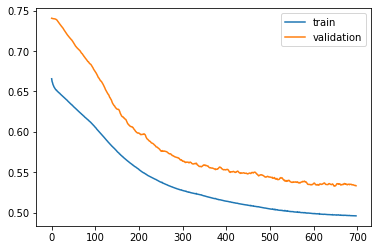

In [56]:
# QUESTA CELLA È PER UN TEST, ELIMINARE POI


# define model
model = Sequential()
model.add(Dense(3, input_dim=6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)#, min_delta=1, verbose=1)
# fit model
history = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), epochs=4000, verbose=0, callbacks=[es])
# evaluate the model
_, train_acc = model.evaluate(tr_x, tr_y, verbose=0)
_, test_acc = model.evaluate(vl_x, vl_y, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, test_acc))
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

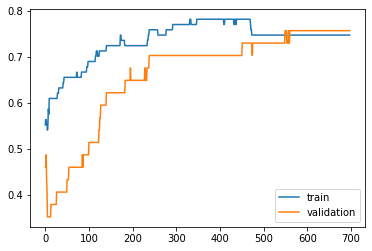

In [57]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.show()

In [58]:
_, accuracy = model.evaluate(tr_x, tr_y) # verbose=0 to suppress output
print('Accuracy: %.2f' % (accuracy*100)) 

3/3 [==============================] - 0s 1ms/step - loss: 0.4958 - accuracy: 0.7471
Accuracy: 74.71


In [44]:
history.history['loss']

[1.1788040399551392,
 1.1690471172332764,
 1.1592868566513062,
 1.1495323181152344,
 1.1414172649383545,
 1.1327897310256958,
 1.1234203577041626,
 1.1155537366867065,
 1.1066395044326782,
 1.0980302095413208,
 1.0889846086502075,
 1.0807464122772217,
 1.0716485977172852,
 1.063429594039917,
 1.054396390914917,
 1.0457872152328491,
 1.0362417697906494,
 1.0257514715194702,
 1.0177024602890015,
 1.0081888437271118,
 0.9982026219367981,
 0.9900999665260315,
 0.9822070002555847,
 0.9736126661300659,
 0.9660114049911499,
 0.9596622586250305,
 0.9531676173210144,
 0.945682942867279,
 0.938459575176239,
 0.932249903678894,
 0.9260717034339905,
 0.9193150401115417,
 0.9135608077049255,
 0.9078443646430969,
 0.9020916223526001,
 0.8967305421829224,
 0.891356885433197,
 0.8864869475364685,
 0.8816704750061035,
 0.877101480960846,
 0.8725010752677917,
 0.8676726222038269,
 0.8632864952087402,
 0.859117865562439,
 0.8550816774368286,
 0.8510537147521973,
 0.8477462530136108,
 0.8438728451728821,


In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])